In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy
from scipy import stats
from scipy.stats import norm
import os
import pickle
from sklearn.preprocessing import PolynomialFeatures

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsetds
import torch.nn.functional as F
import torch.distributions as tdist
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import itertools
import copy

#from kmeans_pytorch import kmeans

print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True
CUDA_LAUNCH_BLOCKING='1'


GPU available:  True


In [ ]:
### Model parameters
dim_X = 40

N_sim = 2**16

BS = 2**10
eps = 0.025
max_epochs = 300
eps_list = [eps, 0.01,0.02, 0.03, 0.05]

def batch_iterate(features, labels, dest_features, dest_labels, batch_size):
    # handy way I came up with to reduce the number of unnecessary memory allocations
    # in particular this copies to the GPU (and ensures contiguity) only once every batch iteration
    #assert features.shape[0] == labels.shape[0], 'features and labels must have same size along first axis'
    for batch_idx in range((features.shape[0]+batch_size-1)//batch_size):
        start_idx = batch_idx*batch_size
        tmp_features_batch = features[start_idx:(batch_idx+1)*batch_size]
        eff_batch_size = tmp_features_batch.shape[0]
        dest_features[:eff_batch_size] = tmp_features_batch
        if labels is None:
            yield start_idx, eff_batch_size, dest_features[:eff_batch_size], None
        else:
            tmp_labels_batch = labels[start_idx:(batch_idx+1)*batch_size]
            dest_labels[:eff_batch_size] = tmp_labels_batch
            yield start_idx, eff_batch_size, dest_features[:eff_batch_size], dest_labels[:eff_batch_size]

def batch_iterate_alpha(features, labels, dest_features, dest_labels, alphas, dest_alphas, batch_size = BS):
    # handy way I came up with to reduce the number of unnecessary memory allocations
    # in particular this copies to the GPU (and ensures contiguity) only once every batch iteration
    #assert features.shape[0] == labels.shape[0], 'features and labels must have same size along first axis'
    for batch_idx in range((features.shape[0]+batch_size-1)//batch_size):
        start_idx = batch_idx*batch_size        
        tmp_features_batch = features[start_idx:(batch_idx+1)*batch_size]
        eff_batch_size = tmp_features_batch.shape[0]
        tmp_alphas_batch = alphas[start_idx:(batch_idx+1)*batch_size]
        dest_features[:eff_batch_size] = tmp_features_batch
        dest_alphas[:eff_batch_size] = tmp_alphas_batch
        
        if labels is None:
            yield start_idx, eff_batch_size, dest_features[:eff_batch_size], None, dest_alphas[:eff_batch_size]
        else:
            tmp_labels_batch = labels[start_idx:(batch_idx+1)*batch_size]
            dest_labels[:eff_batch_size] = tmp_labels_batch
            yield start_idx, eff_batch_size, dest_features[:eff_batch_size], dest_labels[:eff_batch_size], dest_alphas[:eff_batch_size]

In [ ]:
def save_obj(obj, name ):
    with open(''+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
a = torch.tensor([2,3])

# 1 Data simulator

In [ ]:
class var_es_generator:
    """ 
    Data generator for VaR and ES Case study

    var_es_generator simulates a matrix of input X, an output vector Y
    and true conditional VaR and ES for benchmark.  

    Parameters
    ----------
    dim_X : int, default= Model parameters
        Dimension of input features.
    eps : float, default= Model parameters
        1 - eps is the involved confidence level. 0 < eps < 1.
    lambda_0 : float, default= 0
        Intercept in the polynomial function of conditional mean.
    mu_0 : float, default= 0
        Intercept in the polynomial function of conditional standard deviation.    
    lambda_rs : int, default= None
        Determines random number generation for lambda coefficients.    
    mu_rs : int, default= None
        Determines random number generation for mu coefficients.     
    Attributes
    ----------
    dim_X : int
    eps : float
    lambda_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    mu_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    Notes
    ----------
    Data is sumulated on CPU.    
    """
    def __init__(self, dim_X = dim_X, eps = eps, 
                 lambda_rs = None, mu_rs = None):
        self.dim_X = dim_X
        self.eps = eps

    @staticmethod
    def mean_X(dim_X):
        """
        Generate mean vector of X

        Returns
        -------
        Mean vector 
        """
        return np.zeros(dim_X)
    
    @staticmethod
    def var_X(dim_X, correlation = False):
        """
        Generate covariance matrix of X

        Parameters
        ----------
        correlation : bool, default= False
            If True, return a full symmetric (dim_X, dim_X) covariance matrix,
            else return an identity matrix.
        Returns
        -------
        Covariance matrix 
        """
        
        if correlation == False:
            return np.identity(dim_X)
        else:
            A = np.random.RandomState(100).randn(dim_X,dim_X)
            A = np.matmul(A.T,A)
            A /= A.max()
            np.fill_diagonal(A,1)
            return A
    
    def return_function(self, x, y, true_var, true_es, N_sim, test = False):
        x = torch.from_numpy(x.reshape(N_sim, self.dim_X)).type(torch.FloatTensor)
        y = torch.from_numpy(y.reshape(N_sim,1)).type(torch.FloatTensor) 
        true_var = torch.from_numpy(true_var.reshape(N_sim,-1)).type(torch.FloatTensor)
        true_es = torch.from_numpy(true_es.reshape(N_sim,-1)).type(torch.FloatTensor)
        if test ==False:
            self.mean_x = x.mean(dim = 0,keepdim = True)
            self.std_x = x.std(dim = 0,keepdim = True)
            self.std_y = y.std()
        x -= self.mean_x
        x /= self.std_x
        y /= self.std_y
        return x, y, true_var, true_es, float(self.std_y)

    def poly_function(self, X, coefficient_vector, degree = 2): 
        """
        Compute a multivariate polynomial function of degree 2 from a input and
        coefficient vector.

        Parameters
        ----------
        X : array
            A input vector.
        coefficient_vector: array
            A coefficient vector.
        Returns
        -------
        A real-value of polynomial of degree 2.
        """
        poly = PolynomialFeatures(degree, include_bias=False)
        return np.sum(poly.fit_transform(X) * coefficient_vector, axis = 1)
    
    def simulate(self, N_sim = N_sim, eps = None, dim_X = None, test = False, rs0 = 0, rs1 = 1) :

        """
        Simulate data and wrap to torch.Tensor.
        Parameters
        ----------
        N_sim : int, default= Model parameters
            Number of observations to simulate.
        Returns
        -------
        X : torch.Tensor, shape (N_sim, dim_X)
            Matrix of input
        Y : torch.Tensor, shape (N_sim, 1) 
            Vector of output
        true_var : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional VaR for benchmark. 
        true_es : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional ES for benchmark. 
        mean_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true mean of Y. 
        std_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true standard deviation of Y. 
        """          
        if eps != None:
            self.eps = eps
        if dim_X != None:
            self.dim_X = dim_X
        
        self.lambda_0 = np.random.RandomState(rs0).uniform(0,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.mu_0 = np.random.RandomState(rs1).uniform(0,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )

        self.eps = np.array(self.eps).reshape(-1)
        X = np.random.multivariate_normal(self.mean_X(self.dim_X), self.var_X(self.dim_X, correlation = True), N_sim)

        mean_Y = self.poly_function(X, self.lambda_0)
        std_Y = np.abs(self.poly_function(X, self.mu_0))
        
        Y = np.random.normal(mean_Y, std_Y)
        
        true_VaR = mean_Y.reshape(-1,1) - std_Y.reshape(-1,1)*norm.ppf(self.eps).reshape(1,-1)
        true_ES = mean_Y.reshape(-1,1) + 1/self.eps.reshape(1,-1) * std_Y.reshape(-1,1) * norm.pdf(norm.ppf(self.eps)).reshape(1,-1)

        return self.return_function( X, Y, true_VaR, true_ES, N_sim, test)
    
    def simulate_prob1(self, N_sim = N_sim, eps = None, dim_X = None, test = False, rs0 = 2, rs1 = 3):
        if eps != None:
            self.eps = eps
        if dim_X != None:
            self.dim_X = dim_X
        self.eps = np.array(self.eps).reshape(-1)
        d1 = int(self.dim_X // 3)
        d2 = self.dim_X - d1

        X = np.concatenate([np.random.binomial(1, 0.2, size =(N_sim,d1)), 
                            np.random.multivariate_normal(self.mean_X(d2), self.var_X(d2, correlation = True), N_sim).reshape(N_sim,d2)],
                           axis = 1)
        self.lambda_1= np.random.RandomState(rs0).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.mu_1 = np.random.RandomState(rs1).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )

        mean_Y = self.poly_function(X, self.lambda_1).reshape(-1)
        std_Y = np.abs(self.poly_function(X, self.mu_1)).reshape(-1)

        Y = stats.t.rvs(df = 10, loc = mean_Y, scale = std_Y)
        true_VaR = np.zeros((N_sim, len(self.eps)))
        for i, eps_ in enumerate(self.eps):
            true_VaR[:,i] = stats.t.ppf(q = 1-eps_, df = 10, loc = mean_Y, scale = std_Y).reshape(-1)
        true_ES = mean_Y.reshape(-1,1) +  std_Y.reshape(-1,1)* \
                  (10+(scipy.stats.t(10).ppf(self.eps).reshape(1,-1))**2)/(9*self.eps.reshape(1,-1))\
                  *scipy.stats.t(10).pdf(scipy.stats.t(10).ppf(self.eps)).reshape(1,-1)

        return self.return_function( X, Y, true_VaR, true_ES, N_sim, test)
    
    def simulate_prob2(self, N_sim = N_sim, eps = None, dim_X = None, test = False, rs0 = 4, rs1 = 5, rs2 = 6):
        if eps != None:
            self.eps = eps
        if dim_X != None:
            self.dim_X = dim_X
        self.eps = np.array(self.eps).reshape(-1)
        d1 = int(self.dim_X // 4)
        d2 = self.dim_X - d1

        X = np.concatenate([np.random.binomial(1, 0.2, size =(N_sim,d1)), 
                            np.exp(np.random.multivariate_normal(self.mean_X(d2), self.var_X(d2, correlation = True), N_sim)).reshape(N_sim,d2)],
                           axis = 1)        
        self.lambda_2 = np.random.RandomState(rs0).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.mu_2 = np.random.RandomState(rs1).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.a_2 = np.random.RandomState(rs2).choice(np.arange(self.dim_X),self.dim_X//10,replace=False)

        X1 = X.copy()
        X1[:, self.a_2] = 0
        mean_Y = self.poly_function(X1, self.lambda_2).reshape(-1)
        std_Y = np.abs(self.poly_function(X1, self.mu_2)).reshape(-1)

        Y = np.random.normal(mean_Y, std_Y)
        
        true_VaR = mean_Y.reshape(-1,1) - std_Y.reshape(-1,1)*norm.ppf(self.eps).reshape(1,-1)
        true_ES = mean_Y.reshape(-1,1) + 1/self.eps.reshape(1,-1) * std_Y.reshape(-1,1) * norm.pdf(norm.ppf(self.eps)).reshape(1,-1)

        return self.return_function( X, Y, true_VaR, true_ES, N_sim, test)
        
    def simulate_prob3(self, N_sim = N_sim, eps = None, dim_X = None, test = False, rs0 = 7, rs1 = 8, rs2 = 9):
        if eps != None:
            self.eps = eps
        if dim_X != None:
            self.dim_X = dim_X
        self.eps = np.array(self.eps).reshape(-1)
    
        X = np.random.uniform(-1,1,(N_sim,self.dim_X))
        
        self.lambda_3 = np.random.RandomState(rs0).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.mu_3 = np.random.RandomState(rs1).uniform(-1,1, int(self.dim_X + self.dim_X*(self.dim_X+1)/2) )
        self.a_3 = np.random.RandomState(rs2).choice(np.arange(self.dim_X),self.dim_X//10,replace=False)
        
        X1 = X.copy()
        X1[:, self.a_3] = 0
        mean_Y = self.poly_function(X1, self.lambda_3, 2).reshape(-1)
        std_Y = np.abs(self.poly_function(X1, self.mu_3,2)).reshape(-1)
        mean_Y /= mean_Y.max()
        std_Y /= std_Y.max()

        Y =  np.random.lognormal(mean_Y, std_Y)
        
        true_VaR = np.zeros((N_sim, len(self.eps)))
        true_ES = np.zeros((N_sim, len(self.eps)))

        for i,eps_ in enumerate(self.eps):
            true_VaR[:,i] = np.exp(mean_Y + std_Y*np.sqrt(2)*scipy.special.erfinv(2*(1-eps_)-1))         
            true_ES[:,i] = 0.5*np.exp(mean_Y + 0.5*std_Y**2)*(1 + scipy.special.erf(std_Y/np.sqrt(2) - scipy.special.erfinv(2*(1-eps_)-1)))/eps_

        return self.return_function( X, Y, true_VaR, true_ES, N_sim, test)

In [ ]:
def NRMSE(model, x_train, true, std_y, output_range = None, cross_index = None, aggregate = True):
    """
    Normalized Root-Mean-Square Error
    
    It is Root-Mean-Square Error normalized by the standard error of true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    t_x_batch = torch.empty((BS, x_train.shape[1]), dtype=torch.float32, device=device)
    t_true_batch = torch.empty((BS, true.shape[1]), dtype=torch.float32, device=device)
    if output_range is not None:
        true = true[:,output_range]
    std_true = true.std(dim = 0,keepdim = True)
    samples = x_train.shape[0]
    
    with torch.no_grad():
        model.eval()
        err = 0
        for _,_, x_batch, true_batch in batch_iterate(x_train, true, t_x_batch, t_true_batch, batch_size = BS):
            pred = model(x_batch)
            if cross_index is not None:                
                pred = torch.cat([pred[:,0:1], torch.relu(pred[:,1:])], axis = 1)
                pred = torch.cumsum(pred, dim = 1)
                pred = pred[:, cross_index]
            pred *= std_y 
            err += ((pred[:,0:true.shape[1]] - true_batch)**2).sum(dim = 0,keepdim = True)
        err /= samples
        err = torch.sqrt(err).cpu()/ std_true
    if not aggregate:
        return [float(i) for i in err.reshape(-1)]
    else:
        return float(torch.mean(err))


def qloss(pred, y, eps_ = None):
    """
    Quantile loss
    
    This function computes quantile (pinball) loss.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    if eps_ == None:
        eps_ = eps
    eps_ = torch.Tensor(eps_)
    return float(torch.mean(torch.mean(torch.relu(y.cpu() - pred.cpu()) + eps_*pred.cpu(), 0)))

def q_proba(pred, y):
    """
    Quantile probability
    
    This function computes probability that the target exceed the prediction.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    pred = pred.cpu().reshape(y.shape)
    y = y.cpu()
    return float(sum(y >pred))/len(y)

def huber_loss(pred, y, tau, eps = eps):
    """
    Huber loss
    
    This function computes Huber loss which allows to train quantile model.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    tau : float
        Huber switching threshold.
    eps : float, default = Model parameters
    Returns
    -------
    Huber loss. 
    """
    zero_vector = torch.zeros_like(y)
    u = y - pred
    hu = u**2/(2*tau)*(torch.abs(u)<=tau) + (torch.abs(u) - tau/2)*(torch.abs(u)>tau)
    loss_var = torch.mean((1-eps)*hu*(u>=zero_vector) + eps*hu*(u<zero_vector))
    return loss_var

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    """
    Plot function
    
    This function print all comparison metrics and density plot of predicted and 
    true VaR and ES.

    Parameters
    ----------
    var_train_pre : torch.Tensor 
    var_train_true : torch.Tensor
    es_train_pre : torch.Tensor
    es_train_true : torch.Tensor
    var_test_pre : torch.Tensor
    var_test_true : torch.Tensor
    es_test_pre : torch.Tensor
    es_test_true : torch.Tensor
    Returns
    -------
    Print and plot results. 
    """

    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre, var_train_true))
    
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre, var_test_true))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre, es_train_true))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre, es_test_true))

    print('RMSE in-sample VaR: ',RMSE(var_train_pre, var_train_true))
    print('RMSE out-sample VaR: ',RMSE(var_test_pre, var_test_true))

    #print('Quantile loss in-sample: ', qloss(var_train_pre.data, Y_train))
    #print('Quantile loss out-sample: ', qloss(var_test_pre.data, Y_test))

    print('Quantile proba in-sample: ', q_proba(var_train_pre.data, Y_train))
    print('Quantile proba out-sample: ', q_proba(var_test_pre.data, Y_test))

#2 Random layers

In [ ]:
class Rademacher_dist:
    """ 
    Rademacher distribution

    Rademacher_dist is a generator of Rademacher distribution taking values 
    +1 and −1 with probability 1/2 for each. Rademacher_dist serves to create 
    random projection matrix.
    """
    def sample(dim):
        """
        Simulate data drawn from Rademacher distribution.

        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return 2*tdist.bernoulli.Bernoulli(0.5).sample(dim)-1
        
class Achlioptas_dist:
    """ 
    Achlioptas distribution

    Achlioptas_dist is a generator of Rademacher distribution taking values 
    +√3, 0 and −√3 with probability 1/6, 2/3, 1/6 respectively. Rademacher_dist 
    serves to create random projection matrix.  
    """
    def sample(dim):
        """
        Simulate data drawn from Achlioptas distribution.
        
        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return (tdist.categorical.Categorical(probs=torch.tensor([1/6,2/3,1/6])).sample(dim) -1)*np.sqrt(3)

class Randomprojection:
    """ 
    Random projection mapping

    Randomprojection maps the input data into a new dimentional space, a bias 
    term can be added to transformed data, and then an activation function can 
    be applied. Randomprojection can transform the data several times but it is 
    not necessary.

    Parameters
    ----------
    Layers : list, default= [10,100]
        The first element of this list is the dimension of input, the second 
        element is the dimension of new space. If the length of list d is more
        than two, this means the transformation is applied d-1 times into the 
        corresponding dimension of new spaces. 
    bias : bool, default= True
        Whether to apply the intercept for the transformation.
    activation : function, default= F.relu
        Activation function.
    projection : string, default = 'Gauss'
        The distribution of Random projection: 'Gauss' for Gaussian distribution,
        'Rademacher' for Rademacher distribution and 'Achlioptas' for Achlioptas 
        distribution.        
    random_state : int, default= None
        Determines random number generation for random projection matrix.     
    Attributes
    ----------
    dist : distribution
        Random projection distribution.
    W : list
        List of weights (cf. Random projection matricies). The length of this
        list is equal to the one of Layers minus one.
    b : list
        List of biases. It is empty if bias = False
    activation : function
        Activation function.
    bias : bool
        Whether to apply the intercept for the transformation.
    """
    def __init__(self, Layers = [10, 100], bias = True, activation = F.relu, projection = 'Gauss', random_state = None):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], Layers[-1])
        """
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

In [ ]:
class LR_readout_cuml:
    """
    Linear regression (for readout layer) by matrix inversion 

    LR_readout_cuml performs linear regression using the fast GPU matrix 
    inversion in cuml package.

    Parameters
    ----------
    intercept : bool, default = True
        Whether to compute the intercept for this model.
    normalize : bool, default = False
        Whether to normalize the input matrix X.
    regularization_weight : float, defalut = 0 
        Regularization strength. Larger values specify stronger regularization.
    Attributes
    ----------
    lin_reg : Linear regression model
    """
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        """
        Fit Regression model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            Output matrix (vector).
        Returns
        -------
        self with self.lin_reg is fitted 
        """
        self.lin_reg.fit(X,y)
        
    def predict(self, X) :
        """
        Predict output by input matrix X and fitted model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        y : torch.Tensor
            Output matrix (vector).
        """
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        """
        Compute quadratic loss for prediction from input X and true output y . 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            True output matrix (vector).
        Returns
        -------
        Qudratic loss
        """
        return torch.mean((self.predict(X)*weight - y.reshape(-1))**2)

#3 Readout layers optimization

In [ ]:
class NN_nlayers(nn.Module):
    """
    Neural network model 

    Parameters
    ----------
    Layers : list
        List of layers. The first and last element of list are input and output
        units which are fixed by the model setup. The mid elements specify units
        of hidden layers. For example, Layers =[40,50,80,1] means NN inputing 
        40-dimension vector and outputing a value with 2 hidden layers of 50 and
        80 units, respectively.  
    activation : function, default = F.relu
        Activation function.
    Attributes
    ----------
    hidden : list
        List of hidden layers. 
    activation: function
        Activation function.
    """

    def __init__(self, Layers, activation = F.elu, normalization = False, dropout_input = 0., dropout_hidden = 0.):
        super(NN_nlayers, self).__init__()
        self.dense_bn = nn.BatchNorm1d(Layers[1])
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout0 = nn.Dropout(self.dropout_input)
        self.dropout1 = nn.Dropout(self.dropout_hidden)
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
        self.activation = activation
        self.normalization = normalization
        self.init_weights()
    def forward(self, x):
        """
        Perform the calculation by Neural network model 

        Parameters
        ----------
        x : torch.Tensor
            Input matrix.
        Returns
        ----------
        output  torch.Tensor calculated by Neural network model
        """

        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.dropout0(x)
                x = linear_transform(x)
                if self.normalization:
                    x = self.dense_bn(x)
                x = self.activation(x)
            else:
                x = self.dropout1(x)
                #self.y = x.clone()
                x = linear_transform(x)
        return x

    def init_weights(self):
        self.hidden.apply(NN_nlayers.initialization)

    @staticmethod
    def initialization(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.001)


In [ ]:
def predict_net(model, x_train, std_y, return_tensor = True, batch_size = BS):    
    pred = torch.empty((x_train.shape[0],model.hidden[-1].out_features), dtype= torch.float32)
    t_x_batch = torch.empty((batch_size, x_train.shape[1]), dtype=torch.float32, device=device)
       
    with torch.no_grad():
        model.eval()
        for start_idx, eff_batch_size, x_batch, _ in batch_iterate(x_train, None, 
                                                                 t_x_batch, None,batch_size):            
            pred[start_idx:start_idx + eff_batch_size,:].copy_(std_y*model(x_batch))
    if return_tensor :
        return pred
    else:
        return pred.numpy()

In [ ]:
def train_var_RUbased_fullbatch(model, x_train, y_train , eps_list = [eps,0.5],
                         learning_rate = 0.1, regu_h_type = 'Linf2', regu_o_type = 'L22',
                         regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False, 
                         schedule_lr = False,
                         epochs=max_epochs, early_stop = 1e-8, verbose = None, batchsize = BS) :
    """
    Train quantile loss function using full batch data

    This function trains Pytorch neural network module by Adam optimizer using
    full batch data. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    early_stop : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """
    para_h = sum(model.hidden[0].weight.shape)
    para_o = sum(model.hidden[1].weight.shape)

    if regu_o_type == 'L11':
        regu_o = lambda layer : torch.norm(layer.weight, p = 1)
    elif regu_o_type == 'L22':
        regu_o = lambda layer : torch.norm(layer.weight)
    elif regu_o_type == 'L21':
        regu_o = lambda layer : torch.norm(torch.norm(layer.weight, dim = 0), p = 1)
    elif regu_o_type == 'Linf1':
        regu_o = lambda layer : torch.norm(torch.max(layer.weight, dim = 0).values, p = 1)
    elif regu_o_type == 'L22all':
        regu_o = lambda layer : torch.norm(layer.weight)
        regu_h = lambda layer : torch.norm(layer.weight)
        regu_h_weight = regu_o_weight = max(regu_h_weight, regu_o_weight)

    if regu_h_type == 'Linf1':
        regu_h = lambda layer : torch.norm(torch.max(layer.weight, dim = 0).values, p = 1)
    elif regu_h_type == 'Linf2':
        regu_h = lambda layer : torch.norm(torch.max(layer.weight, dim = 0).values)

    
    optimizer_var = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler_var = MultiStepLR(optimizer_var, milestones = [5,10], gamma=0.5)
    
  
    err, best_err = np.inf, np.inf
 
    if isinstance(eps_list,list) == False:
        eps_list = [eps_list]
    if verbose != None:
        print('===Train VaR process===')

    t_x_batch = torch.empty((batchsize, x_train.shape[1]), dtype=torch.float32, device=device)
    t_y_batch = torch.empty((batchsize, y_train.shape[1]), dtype=torch.float32, device=device)
        
    for i in range(epochs):
        if abs(err) < early_stop:
            break
        for _, _, x_batch, y_batch in batch_iterate(x_train, y_train, t_x_batch, t_y_batch, batch_size = batchsize):
            optimizer_var.zero_grad()
            
            q = model(x_batch)
            
            loss_var = torch.mean(torch.relu(y_batch - q) + torch.tensor(eps_list).to(device)*q)
            #loss_var = torch.mean(torch.relu(y_batch - q)*(1-torch.tensor(eps_list).to(device)) + torch.tensor(eps_list).to(device)*torch.relu(q-y_batch))
                   
            loss_var += regu_h_weight*regu_h(model.hidden[0]) + regu_o_weight*regu_o(model.hidden[1])

            if cross_constraint:
                #print('a')
                t_eps_list = torch.tensor(eps_list).sort(descending=True)[0]
                loss_var = torch.mean(torch.relu(y_batch-q[:,0:1]) + t_eps_list[0]*q[:,0:1])
                for i,eps_ in enumerate(t_eps_list[1:]):
                    add = torch.relu(q[:,1:(i+2)]).sum(dim = 1 , keepdim = True)
                    #print(add.shape)
                    loss_var += torch.mean(torch.relu(y_batch-q[:,0:1]- add) + eps_*(q[:,0:1]+add))
       
            loss_var.backward()
            optimizer_var.step()

        if schedule_lr:
            scheduler_var.step()
            try: 
                scheduler_h.step()
            except:
                pass

        with torch.no_grad():
            model.eval() 
            err = 0
            for _, _, x_batch, y_batch in batch_iterate(x_train, y_train, t_x_batch, t_y_batch, batch_size =  batchsize):
                q = model(x_batch)
                err += torch.sum(torch.sum(torch.relu(y_batch - q) + torch.tensor(eps_list).to(device)*q, 0))
                #err += torch.sum(torch.relu(y_batch - q)*(1-torch.tensor(eps_list).to(device)) + torch.tensor(eps_list).to(device)*torch.relu(q-y_batch))
                if cross_constraint:
                    err += torch.sum(torch.relu(y_batch-q[:,0:1]) + t_eps_list[0]*q[:,0:1])                  
                    for i,eps_ in enumerate(t_eps_list[1:]):
                        add = torch.relu(q[:,1:(i+2)]).sum(dim = 1 , keepdim = True)
                        err += torch.sum(torch.relu(y_batch -q[:,0:1]- add) + eps_*(q[:,0:1]+add))
       
            err = err/x_train.shape[0]/len(eps_list)
            err += regu_h_weight*regu_h(model.hidden[0]) + regu_o_weight*regu_o(model.hidden[1])
            err = float(err.data.item())
            if err < best_err:
                best_err = err
                best_state = copy.deepcopy(model.state_dict())

        if (verbose != None) and (verbose != -1) : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        
        
    if (verbose != None) or (verbose == -1) : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model.load_state_dict(best_state)
    
    return best_err
    

In [ ]:
def evaluate_qloss(model, x_test, y_test, eps_list, output_range = None):
    t_x_batch = torch.empty((BS, x_test.shape[1]), dtype=torch.float32, device=device)
    t_y_batch = torch.empty((BS, y_test.shape[1]), dtype=torch.float32, device=device)

    samples = x_test.shape[0]
    
    with torch.no_grad():
        model.eval()
        err = 0
        for _,_, x_batch, y_batch in batch_iterate(x_test, y_test, t_x_batch, t_y_batch, batch_size = BS):
            q = model(x_batch)
            err += torch.sum(torch.relu(y_batch - q) + torch.tensor(eps_list).to(device)*q, 0)
        err /= samples
                
    if output_range == None:
        return float(torch.mean(err))
    else:
        return float(torch.mean(err.reshape(-1)[output_range]))

#5 Two-step approach

## 5.1 Value at Risk

In [ ]:
eps_list = [0.5,0.01,0.025, 0.1]
cross_index = list(np.array(eps_list).argsort()[::-1])

In [ ]:
eps_list = [0.025]
dim_X =40
data_generator = var_es_generator(dim_X = dim_X)
X_train, Y_train, true_VaR_train, true_ES_train, std_Y = data_generator.simulate(N_sim, eps_list)
X_test, Y_test, true_VaR_test, true_ES_test,_= data_generator.simulate(N_sim, eps_list, test = True)

In [ ]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,min(dim_X*10,600),1], activation =F.relu, normalization=False).to(device)
var_NN.init_weights()
train_var_RUbased_fullbatch(var_NN, X_train, Y_train, eps_list = eps_list[0],
                            epochs=32, early_stop = 1e-8, verbose = 10, batchsize = BS,
                            learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                            regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False)

===Train VaR process===
[iter 0] err = 0.066
[iter 10] err = 0.056
[iter 20] err = 0.055
[iter 30] err = 0.055
[iter 31] err = 0.055
Best error = 0.053414784371852875
CPU times: user 6.12 s, sys: 468 ms, total: 6.59 s
Wall time: 14.6 s


In [ ]:
print('NRMSE in-sample VaR: ',NRMSE(var_NN, X_train, true_VaR_train, std_Y, output_range=[0]))
print('NRMSE out-sample VaR: ',NRMSE(var_NN, X_test, true_VaR_test, std_Y, output_range=[0]))

NRMSE in-sample VaR:  0.258506178855896
NRMSE out-sample VaR:  0.26412835717201233


In [ ]:
var_NN_multi = NN_nlayers(Layers=[dim_X,min(dim_X*10,600),len(eps_list)], activation =F.relu, normalization=False).to(device)

In [ ]:
%%time
var_NN_multi.init_weights()
var_NN_multi.dropout_hidden = 0.
train_var_RUbased_fullbatch(var_NN_multi, x_train= X_train, y_train= Y_train, eps_list = eps_list,
                            epochs=16, early_stop = 1e-8, verbose = 5, batchsize = BS,
                            learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                            regu_h_weight = 0.0, regu_o_weight = 0.0)

===Train VaR process===
[iter 0] err = 0.066
[iter 5] err = 0.058
[iter 10] err = 0.057
[iter 15] err = 0.057
[iter 15] err = 0.057
Best error = 0.05536738410592079
CPU times: user 2.29 s, sys: 45.2 ms, total: 2.34 s
Wall time: 2.37 s


In [ ]:
print('NRMSE in-sample VaR: ',NRMSE(var_NN_multi, X_train, true_VaR_train,std_Y,aggregate=False))
print('NRMSE out-sample VaR: ',NRMSE(var_NN_multi, X_test, true_VaR_test,std_Y,aggregate=False))

NRMSE in-sample VaR:  [0.29159170389175415]
NRMSE out-sample VaR:  [0.2959637939929962]


## David's idea

In [ ]:
class qinterpolation_net(nn.Module):

    def __init__(self, input_dim = dim_X, h_unit = dim_X*2, nb_cut_point = dim_X*5, activation = F.softplus,
                 upper_alpha = 1., lower_alpha = 0., regular = False, simple = False, device = device):
        super(qinterpolation_net, self).__init__()

        upper_alpha = min(upper_alpha, 1.)
        lower_alpha = max(lower_alpha, 0.)
        d_alpha = (upper_alpha - lower_alpha)/(nb_cut_point)
        self.hidden1 = nn.Linear(input_dim, h_unit)
        self.hidden2 =nn.Linear(h_unit, nb_cut_point+1)
        self.simple = simple
        if simple:
            self.hidden2 = nn.Linear(h_unit,1)
            self.weight_out = torch.nn.Parameter(0.001*torch.ones((1, nb_cut_point), dtype = torch.float32))

        self.activation = activation
        self.bias_out = torch.nn.Parameter(torch.tensor([[0.001]], dtype=torch.float32))
        
        if regular:
            self.alpha_vector = torch.linspace(start = lower_alpha, end = upper_alpha, steps = nb_cut_point+1).reshape(-1).to(device)
        else:
            self.alpha_vector = torch.cat([torch.tensor([lower_alpha]), (lower_alpha + torch.rand(nb_cut_point-1)*(upper_alpha - lower_alpha)).sort()[0], 
                                           torch.tensor([upper_alpha])]).reshape(-1).to(device)
        self.init_weights()
    def forward(self, x, alpha):
        alpha = alpha.reshape(-1,1)
        alpha = torch.min(self.alpha_vector, alpha)
        alpha = alpha[:,1:]-alpha[:,:-1]
        x = self.activation(self.hidden1(x))
        x = self.hidden2(x)
        if self.simple:
            out = x[:,0:1]*self.bias_out + torch.sum(self.activation(x[:,0:1]*self.weight_out)*alpha, dim = 1, keepdim = True)
        else:
            out = x[:,0:1] + torch.sum(alpha*self.activation(x[:,1:]), dim = 1, keepdim=True)
        return out.reshape(-1,1)

    def init_weights(self):
        self.hidden1.apply(self.initialization)
        self.hidden2.apply(self.initialization)

    def initialization(self,m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight)
            try:
                m.bias.data.fill_(0.001)
            except:
                pass

In [ ]:
def train_qinterpolation_net(model, x_train, y_train , sample_alpha, learning_rate = 0.1,
                            epochs=max_epochs, early_stop = 1e-8, verbose = None, batchsize = BS) :
    optimizer_var = torch.optim.Adam(model.parameters(), lr = learning_rate)    
    sample_alpha = torch.as_tensor(sample_alpha).reshape(-1,1)
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')

    t_x_batch = torch.empty((batchsize, x_train.shape[1]), dtype=torch.float32, device=device)
    t_y_batch = torch.empty((batchsize, y_train.shape[1]), dtype=torch.float32, device=device)
    t_alpha_batch = torch.empty((batchsize, sample_alpha.shape[1]), dtype=torch.float32, device=device)

        
    for i in range(epochs):
        if abs(err) < early_stop:
            break
        for _, _, x_batch, y_batch, alpha_batch in batch_iterate_alpha(x_train, y_train, t_x_batch, t_y_batch, 
                                                                              sample_alpha, t_alpha_batch, batch_size = batchsize):
            optimizer_var.zero_grad()
            
            q = model(x_batch, alpha_batch)
            
            loss_var = torch.mean(torch.relu(y_batch - q) + (1.-alpha_batch)*q)                            
       
            loss_var.backward()
            optimizer_var.step()

        with torch.no_grad():
            model.eval() 
            err = 0
            for _, _, x_batch, y_batch, alpha_batch in batch_iterate_alpha(x_train, y_train, t_x_batch, t_y_batch, 
                                                                              sample_alpha, t_alpha_batch, batch_size = batchsize):
                q = model(x_batch, alpha_batch)
                err += torch.sum(torch.relu(y_batch - q) + (1.-alpha_batch)*q)
            
            err = err/x_train.shape[0]
            err = float(err.data.item())
            if err < best_err:
                best_err = err
                best_state = copy.deepcopy(model.state_dict()) 

        if (verbose != None) and (verbose != -1) : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        
        
    if (verbose != None) or (verbose == -1) : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model.load_state_dict(best_state)
    #model.eval()
    return best_err

In [ ]:
def NRMSE_qinterpolation(model, x_train, true, std_y, alpha_list, batch_size = BS):
    
    sample_alpha = torch.ones([x_train.shape[0], len(alpha_list)], dtype= torch.float32)
    sample_alpha *= torch.as_tensor(alpha_list).reshape(1,-1)
    std_true = true.std(dim = 0,keepdim = True)
    t_x_batch = torch.empty((batch_size, x_train.shape[1]), dtype=torch.float32, device=device)
    t_true_batch = torch.empty((batch_size, true.shape[1]), dtype=torch.float32, device=device)
    t_alpha_batch = torch.empty((batch_size, sample_alpha.shape[1]), dtype=torch.float32, device=device)
    
    with torch.no_grad():
        model.eval()
        err = 0
        for _, eff, x_batch, true_batch, alpha_batch in batch_iterate_alpha(x_train, true, 
                                                                 t_x_batch, t_true_batch,
                                                                 sample_alpha, t_alpha_batch, batch_size):
            pred = torch.empty((eff, len(alpha_list)), dtype=torch.float32, device=device)
            for i in range(len(alpha_list)):
                pred[:,i:i+1] = model(x_batch, alpha_batch[:,i:i+1])
            pred *= std_y
            err += ((pred - true_batch[:,0:len(alpha_list)])**2).sum(dim = 0,keepdim = True)
        err /= x_train.shape[0]
        err = torch.sqrt(err).cpu() / std_true[:,0:len(alpha_list)]
    try:
        return float(err)
    except:
        return [float(i) for i in err.reshape(-1)]

In [ ]:
def predict_qinterpolation(model, x_train, std_y, alpha_list, return_tensor = True, batch_size = BS):
    
    sample_alpha = torch.ones([x_train.shape[0], len(alpha_list)], dtype= torch.float32)
    sample_alpha *= torch.as_tensor(alpha_list).reshape(1,-1)

    pred = torch.empty((x_train.shape[0], len(alpha_list)), dtype= torch.float32)

    t_x_batch = torch.empty((batch_size, x_train.shape[1]), dtype=torch.float32, device=device)
    t_alpha_batch = torch.empty((batch_size, sample_alpha.shape[1]), dtype=torch.float32, device=device)
    
    with torch.no_grad():
        model.eval()
        for start_idx, eff_batch_size, x_batch, _, alpha_batch in batch_iterate_alpha(x_train, None, 
                                                                 t_x_batch, None,
                                                                 sample_alpha, t_alpha_batch, batch_size):
            for i in range(len(alpha_list)):
                pred[start_idx:start_idx + eff_batch_size,i:i+1].copy_(std_y*model(x_batch, alpha_batch[:,i:i+1]))
    if return_tensor :
        return pred
    else:
        return pred.numpy()

In [ ]:
eps_list = [0.025]
dim_X =40
data_generator = var_es_generator(dim_X = dim_X)
X_train, Y_train, true_VaR_train, true_ES_train, std_Y = data_generator.simulate(N_sim, eps_list)
X_test, Y_test, true_VaR_test, true_ES_test, _= data_generator.simulate(N_sim, eps_list, test = True)

In [ ]:
var_NN = NN_nlayers(Layers=[dim_X,min(dim_X*10,600),1], activation =F.relu, normalization=False).to(device)

In [ ]:
%%time
var_NN.init_weights()
train_var_RUbased_fullbatch(var_NN, X_train, Y_train, eps_list = eps_list[0],
                            epochs=32, early_stop = 1e-8, verbose = 10, batchsize = BS,
                            learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                            regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False)
print('======')
print('NRMSE in-sample VaR: ',NRMSE(var_NN, X_train, true_VaR_train, std_Y, output_range=[0]))
print('NRMSE out-sample VaR: ',NRMSE(var_NN, X_test, true_VaR_test, std_Y, output_range=[0]))

===Train VaR process===
[iter 0] err = 0.067
[iter 10] err = 0.057
[iter 20] err = 0.054
[iter 30] err = 0.055
[iter 31] err = 0.056
Best error = 0.05387691780924797
NRMSE in-sample VaR:  0.26585304737091064
NRMSE out-sample VaR:  0.26417532563209534
CPU times: user 4.3 s, sys: 132 ms, total: 4.44 s
Wall time: 4.49 s


In [ ]:
lower = 0.4
upper = 0.6
sample_alpha = lower + (upper - lower)*torch.rand((N_sim,1))
qi_NN = qinterpolation_net(input_dim = dim_X, h_unit= dim_X*3, nb_cut_point= dim_X*10,
                           upper_alpha = upper, lower_alpha = lower).to(device)

In [ ]:
%%time
qi_NN.init_weights()
train_qinterpolation_net(qi_NN, X_train, Y_train , sample_alpha, learning_rate = 0.01,
                            epochs=30, early_stop = 1e-8, verbose = 10, batchsize = BS)

print('NRMSE in-sample VaR: ',NRMSE_qinterpolation(qi_NN, X_train, true_VaR_train,std_Y, alpha_list = [0.5]))
print('NRMSE out-sample VaR: ',NRMSE_qinterpolation(qi_NN, X_test, true_VaR_test,std_Y, alpha_list = [0.5]))

===Train VaR process===
[iter 0] err = 0.599
[iter 10] err = 0.569
[iter 20] err = 0.568
[iter 29] err = 0.568
Best error = 0.5677510499954224
NRMSE in-sample VaR:  0.6147496104240417
NRMSE out-sample VaR:  0.6141307950019836
CPU times: user 3.88 s, sys: 103 ms, total: 3.98 s
Wall time: 4.05 s


In [ ]:
not isinstance(a, int)

True

In [ ]:
def compa_func(alpha_l=[0.2], dim_X = 10, lower = 0.7, upper = 1, rs0 = None, rs1 = None, density_plot = False, result_print = True ):
    eps_l = [1-i for i in alpha_l]
    l_NRMSE_standard_train = []
    l_NRMSE_standard_test = []
    l_NRMSE_2layer_train =[]
    l_NRMSE_2layer_test = []

    pred_standard_test = np.empty((N_sim, len(alpha_l)), dtype= np.float32)
    pred_2layer_test = np.empty((N_sim, len(alpha_l)), dtype= np.float32)
  
    if not isinstance(rs0, int) or not isinstance(rs1, int):
        rs0 = np.random.randint(0,10000)
        rs1 = rs0+1
    if len(alpha_l) == 1 and result_print:
        verbose = 30
    else:
        verbose = None

    data_generator = var_es_generator(dim_X = dim_X)
    X_train, Y_train, true_VaR_train, true_ES_train, std_Y = data_generator.simulate(N_sim, eps_l, rs0=rs0, rs1=rs1)
    X_test, Y_test, true_VaR_test, true_ES_test,_= data_generator.simulate(N_sim, eps_l, test = True, rs0=rs0, rs1=rs1)
    
    standard_NN = NN_nlayers(Layers=[dim_X, min(dim_X*10,600), 1], activation =F.relu, normalization=False).to(device)
    twolayer_NN = NN_nlayers(Layers=[dim_X, dim_X*2,min(dim_X*10,600), 1], activation =F.relu, normalization=False).to(device)
    multi_NN = NN_nlayers(Layers = [dim_X, min(dim_X*10,600), len(eps_l)], activation =F.relu, normalization=False).to(device)
    qi_NN_simple = qinterpolation_net(input_dim = dim_X, h_unit= dim_X*2, nb_cut_point= dim_X*10, activation=F.relu,
                              upper_alpha = upper, lower_alpha = lower, simple = True).to(device)
    qi_NN_nonregular = qinterpolation_net(input_dim = dim_X, h_unit= dim_X*2, nb_cut_point= dim_X*10, activation=F.relu,
                              upper_alpha = upper, lower_alpha = lower, simple = False).to(device)
    qi_NN_regular = qinterpolation_net(input_dim = dim_X, h_unit= dim_X*2, nb_cut_point= dim_X*10, activation=F.relu,
                              upper_alpha = upper, lower_alpha = lower, regular = True).to(device)

    if result_print: print('Empirical probability of true label being lower than true VaR (alpha) = ',
          [float(i) for i in (true_VaR_train>std_Y*Y_train).sum(axis = 0)/N_sim])
    
    if result_print: print('====== One hidden layer net ======')
    for i,eps_ in enumerate(eps_l):
        standard_NN.init_weights()        
        train_var_RUbased_fullbatch(standard_NN, X_train, Y_train, eps_list = eps_,
                            epochs=32, early_stop = 1e-8, verbose = verbose, batchsize = BS,
                            learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                            regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False)
        
        l_NRMSE_standard_train.append(
            NRMSE(standard_NN, X_train, true_VaR_train, std_Y, output_range=[i]))
        l_NRMSE_standard_test.append(
            NRMSE(standard_NN, X_test, true_VaR_test, std_Y, output_range=[i]))
        pred_standard_test[:,i:i+1] = predict_net(standard_NN, X_test, std_Y, return_tensor = False)   
    if result_print: print('NRMSE in-sample VaR = ',l_NRMSE_standard_train)
    if result_print: print('NRMSE out-sample VaR = ',l_NRMSE_standard_test)

    if result_print: print('====== Two hidden layer net ======')
    for i,eps_ in enumerate(eps_l):
        twolayer_NN.init_weights()
        train_var_RUbased_fullbatch(twolayer_NN, X_train, Y_train, eps_list = eps_,
                                epochs=32, early_stop = 1e-8, verbose = verbose, batchsize = BS,
                                learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                                regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False)
        l_NRMSE_2layer_train.append(
            NRMSE(twolayer_NN, X_train, true_VaR_train, std_Y, output_range=[i]))
        l_NRMSE_2layer_test.append(
            NRMSE(twolayer_NN, X_test, true_VaR_test, std_Y, output_range=[i]))
        pred_2layer_test[:,i:i+1] = predict_net(twolayer_NN, X_test, std_Y, return_tensor = False)
    if result_print: print('NRMSE in-sample VaR = ',l_NRMSE_2layer_train)
    if result_print: print('NRMSE out-sample VaR = ',l_NRMSE_2layer_test)

    if result_print: print('====== Multi output net ======')
    train_var_RUbased_fullbatch(multi_NN, X_train, Y_train, eps_list = eps_l,
                                epochs=64, early_stop = 1e-8, verbose = verbose, batchsize = BS,
                                learning_rate =0.01, regu_h_type = 'Linf2', regu_o_type = 'L22', schedule_lr = False,
                                regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False)
    l_NRMSE_multi_train = NRMSE(multi_NN, X_train, true_VaR_train,std_Y, aggregate = False)
    l_NRMSE_multi_test = NRMSE(multi_NN, X_test, true_VaR_test,std_Y, aggregate = False)
    pred_multi_test = predict_net(multi_NN, X_test, std_Y, return_tensor = False)   
    if result_print: print('NRMSE in-sample VaR = ',l_NRMSE_multi_train)
    if result_print: print('NRMSE out-sample VaR = ',l_NRMSE_multi_test) 

    if result_print: print('====== Quantile interpolation net ( simple - non regular) ======')
    sample_alpha = lower + (upper - lower)*torch.rand((N_sim,1))
    train_qinterpolation_net(qi_NN_simple, X_train, Y_train , sample_alpha, learning_rate = 0.01,
                                epochs=32, early_stop = 1e-8, verbose = verbose, batchsize = BS)
    l_NRMSE_qinet_simple_train = NRMSE_qinterpolation(qi_NN_simple, X_train, true_VaR_train,std_Y, alpha_list = alpha_l)
    l_NRMSE_qinet_simple_test = NRMSE_qinterpolation(qi_NN_simple, X_test, true_VaR_test,std_Y, alpha_list = alpha_l)
    pred_qinet_simple_test = predict_qinterpolation(qi_NN_simple, X_test, std_Y, alpha_list = alpha_l, return_tensor = False)
    if result_print: print('NRMSE in-sample VaR = ', l_NRMSE_qinet_simple_train)
    if result_print: print('NRMSE out-sample VaR = ', l_NRMSE_qinet_simple_test) 

    if result_print: print('====== Quantile interpolation net (non regular) ======')
    #sample_alpha = lower + (upper - lower)*torch.rand((N_sim,1))
    train_qinterpolation_net(qi_NN_nonregular, X_train, Y_train , sample_alpha, learning_rate = 0.01,
                                epochs=32, early_stop = 1e-8, verbose = verbose, batchsize = BS)
    l_NRMSE_qinet_nonregular_train = NRMSE_qinterpolation(qi_NN_nonregular, X_train, true_VaR_train,std_Y, alpha_list = alpha_l)
    l_NRMSE_qinet_nonregular_test = NRMSE_qinterpolation(qi_NN_nonregular, X_test, true_VaR_test,std_Y, alpha_list = alpha_l)
    pred_qinet_nonregular_test = predict_qinterpolation(qi_NN_nonregular, X_test, std_Y, alpha_list = alpha_l, return_tensor = False)
    if result_print: print('NRMSE in-sample VaR = ', l_NRMSE_qinet_nonregular_train)
    if result_print: print('NRMSE out-sample VaR = ', l_NRMSE_qinet_nonregular_test)     

    if result_print: print('====== quantile interpolation net (regular) ======')
    #sample_alpha = lower + (upper - lower)*torch.rand((N_sim,1))
    train_qinterpolation_net(qi_NN_regular, X_train, Y_train , sample_alpha, learning_rate = 0.01,
                                epochs=32, early_stop = 1e-8, verbose = verbose, batchsize = BS)
    l_NRMSE_qinet_regular_train = NRMSE_qinterpolation(qi_NN_regular, X_train, true_VaR_train,std_Y, alpha_list = alpha_l)
    l_NRMSE_qinet_regular_test = NRMSE_qinterpolation(qi_NN_regular, X_test, true_VaR_test,std_Y, alpha_list = alpha_l)
    pred_qinet_regular_test = predict_qinterpolation(qi_NN_regular, X_test, std_Y, alpha_list = alpha_l, return_tensor = False)
    if result_print: print('NRMSE in-sample VaR = ', l_NRMSE_qinet_regular_train)
    if result_print: print('NRMSE out-sample VaR = ', l_NRMSE_qinet_regular_train)  
    
    if density_plot:
        for i in range(len(alpha_l)):
            if i%2 ==0:
                plt.figure(figsize=(24,16))
                plt.subplot(221)
            else:
                plt.subplot(222)
            g = sns.distplot(pred_standard_test[:,i:i+1], label='Standard NN', hist = False)
            g = sns.distplot(pred_2layer_test[:,i:i+1], label='Two layer NN', hist = False)
            g = sns.distplot(pred_multi_test[:,i:i+1], label='Multi output NN', hist = False)
            g = sns.distplot(pred_qinet_simple_test[:,i:i+1], label='Q-interpolation NN (simple - non regular)', hist = False)
            g = sns.distplot(pred_qinet_nonregular_test[:,i:i+1], label='Q-interpolation NN (non regular)', hist = False)
            g = sns.distplot(pred_qinet_regular_test[:,i:i+1], label='Q-interpolation NN (regular)', hist = False)
            g = sns.distplot(true_VaR_test[:,i:i+1], label='True VaR', color = 'black', hist = False)

            g = plt.title("alpha = "+str(alpha_l[i]), fontsize=20)
            g = plt.xlabel("")
            g = plt.xlim(max(float(true_VaR_test[:,i].min()), float(true_VaR_test[:,i].mode()[0])- float(5*true_VaR_test[:,i].std())),
                         min(float(true_VaR_test[:,i].max()), float(true_VaR_test[:,i].mode()[0])+ float(5*true_VaR_test[:,i].std())))
            g = plt.ylabel("Probability", fontsize=15)
            g = plt.legend(fontsize = 14, loc = 'best',frameon=False)
            if i%2 ==1 or i == len(alpha_l)-1:
                plt.show()
            #
    return l_NRMSE_standard_test, l_NRMSE_2layer_test, l_NRMSE_multi_test, l_NRMSE_qinet_simple_test, l_NRMSE_qinet_nonregular_test, l_NRMSE_qinet_regular_test

def boxplot_compa_func(trail = 20, alpha_l = [0.975, 0.95, 0.9, 0.85, 0.8], dim_X = 20, lower = 0.8, upper = 1, 
                       rs0 = None, rs1 = None, first_density_plot = True, first_result_print = True):
    res=[]
    for i in  tqdm(range(trail)):
        res.append(compa_func(alpha_l, dim_X, lower, upper, rs0, rs1,
                              density_plot = first_density_plot, result_print = first_result_print))
        first_density_plot = False
        first_result_print = False
    res_table = pd.DataFrame(columns=['model','variable', 'value'])
    for i in range(len(res)):
        a = pd.DataFrame(res[i], columns=alpha_l)
        a['model'] = ['Standard', 'Twolayer','Multi','Qi-simple', 'Qi-non regular', 'Qi-regular' ]
        res_table = pd.concat([res_table, a.melt(id_vars=['model'], value_vars=alpha_l)])
    res_table.reset_index(inplace = True, drop = True)

    plt.figure(figsize=(20,7))
    g1 = sns.boxplot(x="variable", y='value', hue = 'model', data=res_table, showfliers = True,
                      showmeans=True, meanprops={"marker":"o",
                                                "markerfacecolor":"black", 
                                                "markeredgecolor":"black",
                                                "markersize":"7"})
            
    plt.xlabel("alpha", fontsize = 14)
    plt.ylabel("out-of-sample NRMSE", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(loc = 0, fontsize = 14, frameon=False)
    plt.show()

Empirical probability of true label being lower than true VaR (alpha) =  [0.0252227783203125, 0.049774169921875, 0.099517822265625, 0.14996337890625]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.5904739499092102, 0.5577159523963928, 0.6443839073181152, 0.6245603561401367]
NRMSE out-sample VaR =  [0.5907105207443237, 0.5603970885276794, 0.637791097164154, 0.617885410785675]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.6546361446380615, 0.7025876641273499, 0.7868382334709167, 0.8835300207138062]
NRMSE out-sample VaR =  [0.6442246437072754, 0.6965559124946594, 0.7682143449783325, 0.8442763090133667]
====== Multi output net ======
NRMSE in-sample VaR =  [0.8607630133628845, 0.8912076950073242, 0.9539478421211243, 0.9948385953903198]
NRMSE out-sample VaR =  [0.8589805960655212, 0.8861324191093445, 0.942949652671814, 0.9799020290374756]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.6995737552642822, 0.55573302507400

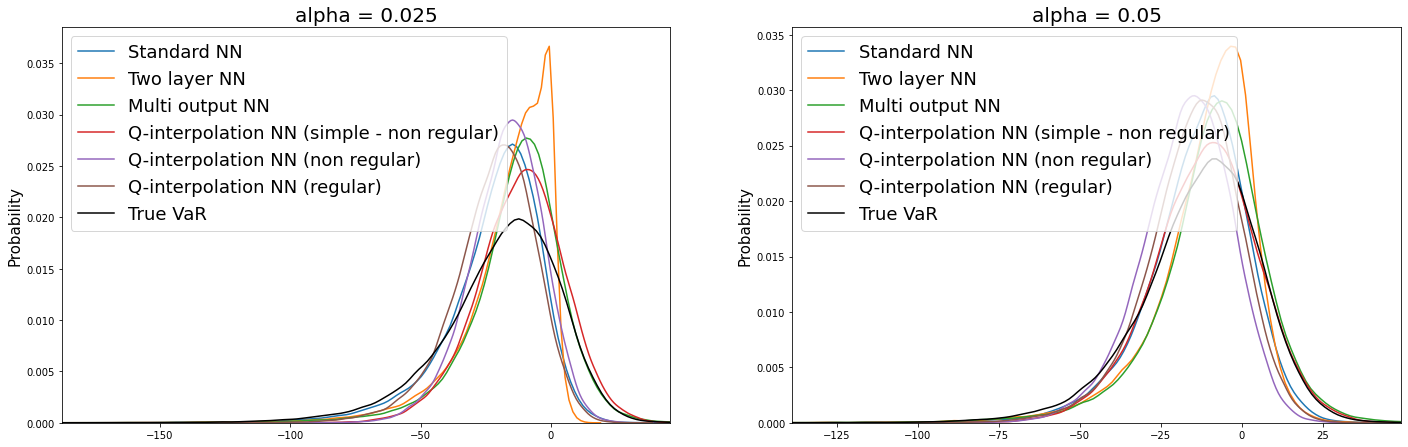

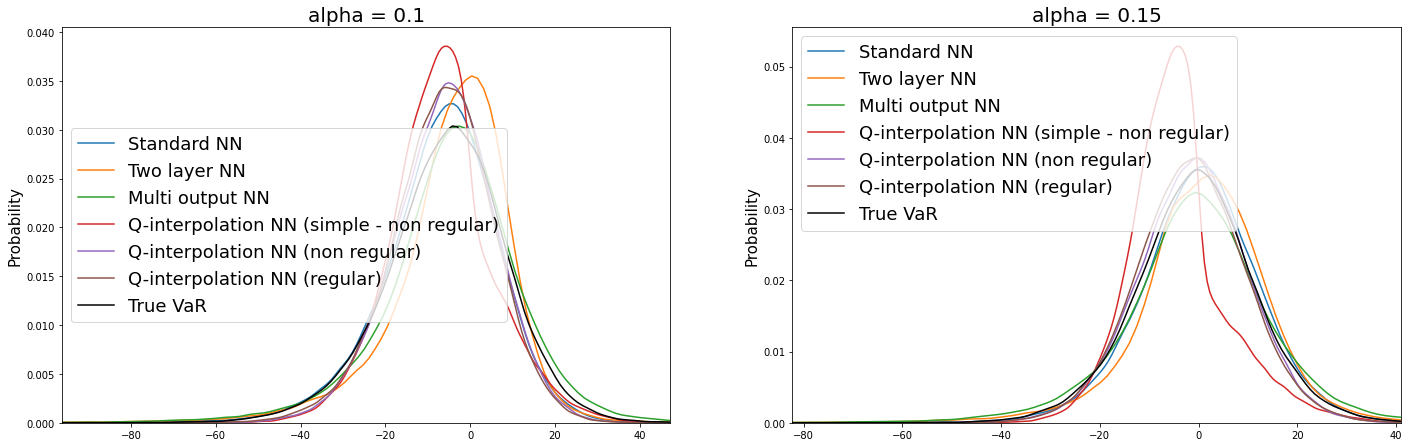

In [ ]:
_ = test(alpha_l = [0.025, 0.05, 0.1, 0.15], dim_X = 40, lower = 0.0, upper = 0.2,density_plot=True)

###a.1 low dim - low alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.02642822265625, 0.052001953125, 0.102874755859375, 0.15264892578125]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.3550563156604767, 0.28397515416145325, 0.2347644865512848, 0.20059078931808472]
NRMSE out-sample VaR =  [0.35293689370155334, 0.2816157341003418, 0.23466841876506805, 0.2017214447259903]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.3095029294490814, 0.2879195511341095, 0.22281832993030548, 0.1959848701953888]
NRMSE out-sample VaR =  [0.3055175542831421, 0.2884413003921509, 0.22303041815757751, 0.1956755667924881]
====== Multi output net ======
NRMSE in-sample VaR =  [0.326606810092926, 0.28600984811782837, 0.22592782974243164, 0.1960296928882599]
NRMSE out-sample VaR =  [0.3234241008758545, 0.28428712487220764, 0.22596269845962524, 0.19689537584781647]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.6943813562393188, 0.538057

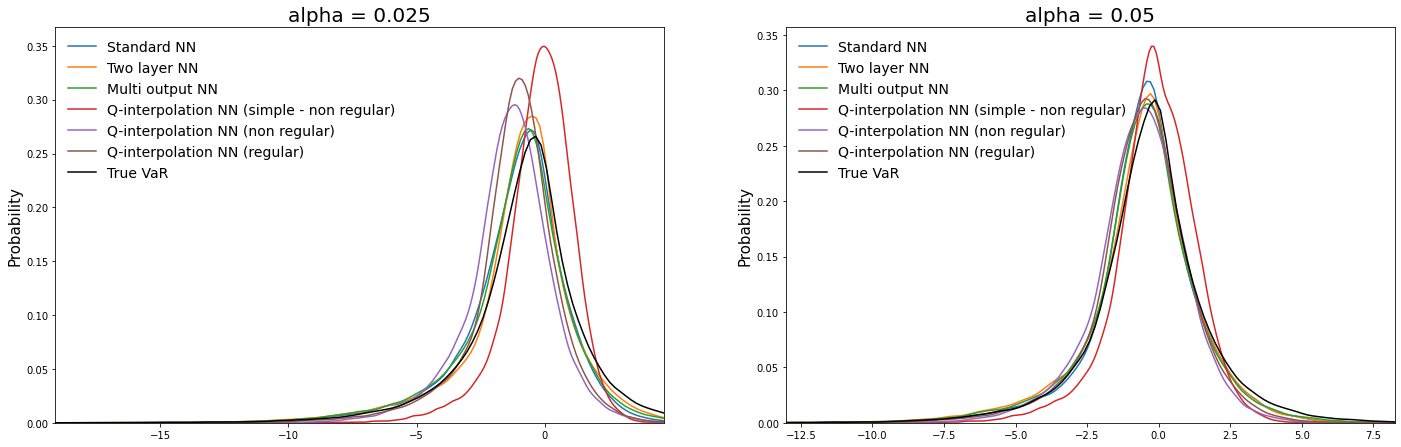

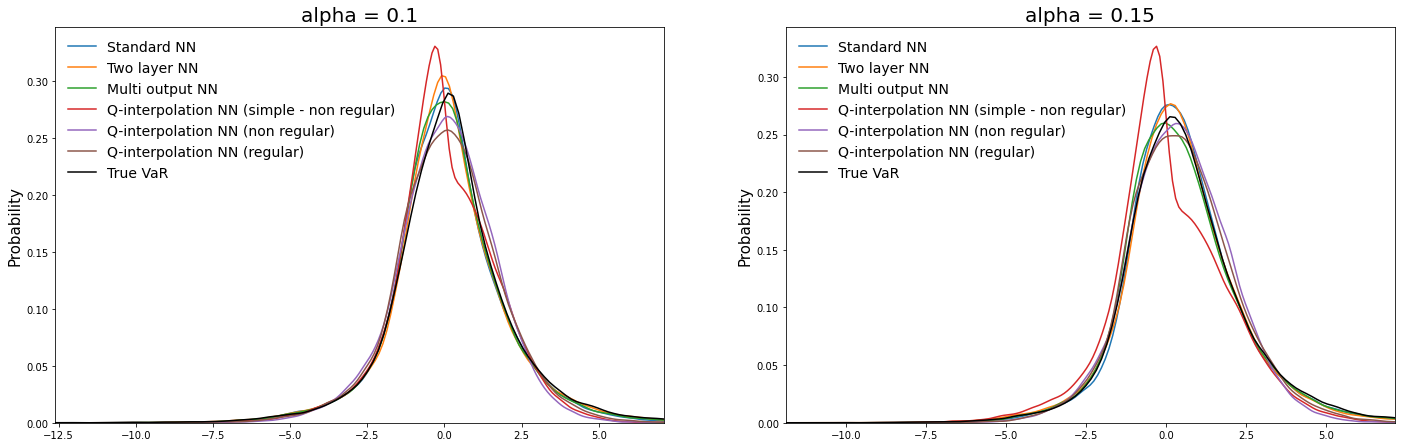

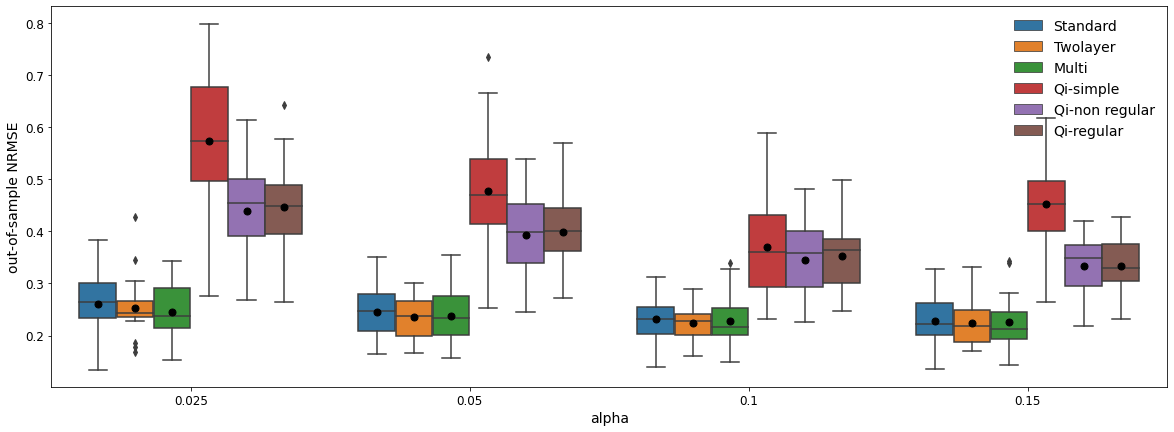

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.025, 0.05, 0.1, 0.15], dim_X = 5, lower = 0.0, upper = 0.2, 
                 first_density_plot = True, first_result_print = True)

###a.2 low dim - medium alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.4018096923828125, 0.502838134765625, 0.6027374267578125]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.13156285881996155, 0.10993572324514389, 0.1091868057847023]
NRMSE out-sample VaR =  [0.13012340664863586, 0.10964442044496536, 0.10959424823522568]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.15191783010959625, 0.09923780709505081, 0.11017271131277084]
NRMSE out-sample VaR =  [0.14947783946990967, 0.09900019317865372, 0.10937102884054184]
====== Multi output net ======
NRMSE in-sample VaR =  [0.15762808918952942, 0.09347663074731827, 0.11629867553710938]
NRMSE out-sample VaR =  [0.15601786971092224, 0.09204426407814026, 0.11607394367456436]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.3662557601928711, 0.19236521422863007, 0.24319443106651306]
NRMSE out-sample VaR =  [0.3618601858615875, 0.19176587462425232, 0.24370169639587402]
====

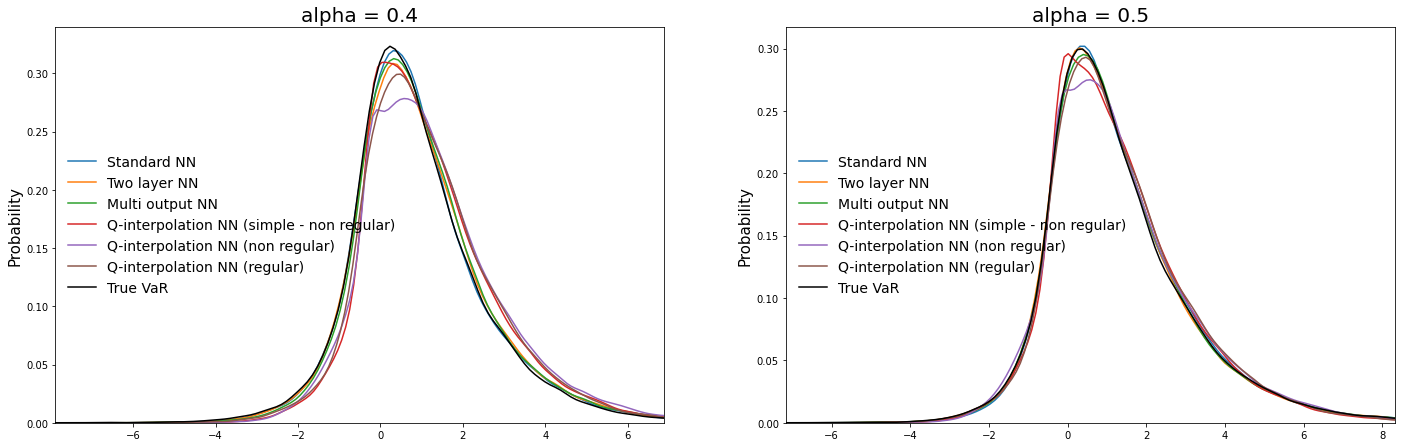

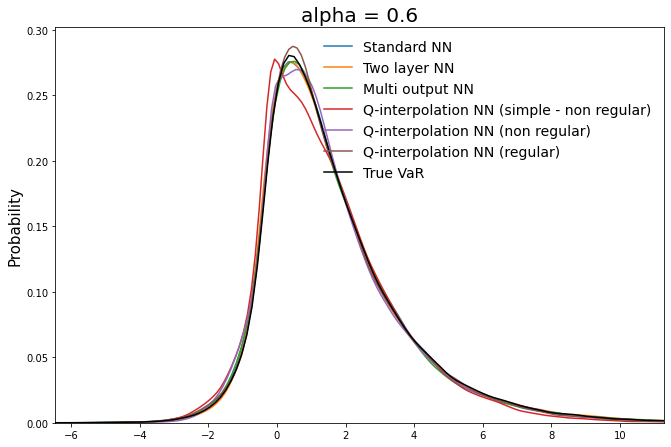

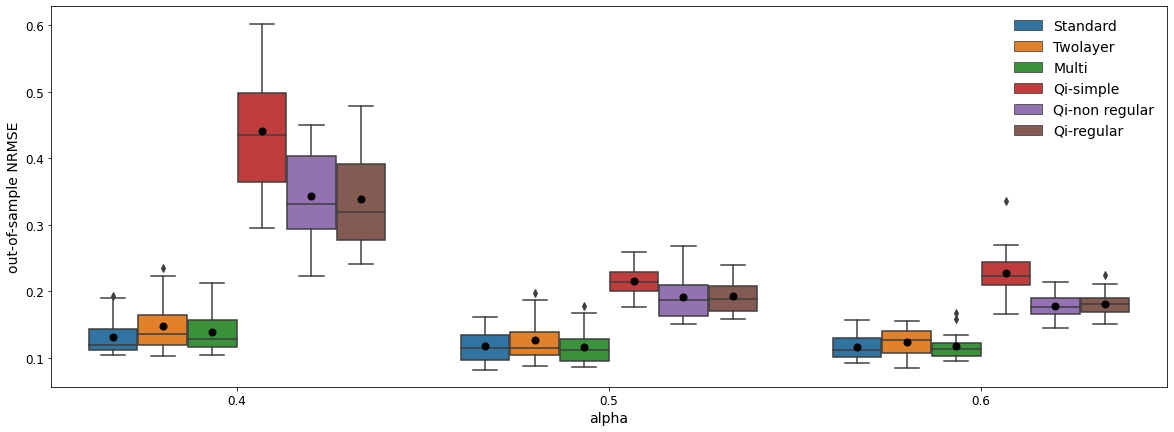

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.4, 0.5, 0.6], dim_X = 5, lower = 0.45, upper = 0.65, 
                 first_density_plot = True, first_result_print = True)

###a.3 low dim - high alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.8524627685546875, 0.900665283203125, 0.9503631591796875, 0.9754486083984375]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.12939795851707458, 0.12604841589927673, 0.11109496653079987, 0.11569403856992722]
NRMSE out-sample VaR =  [0.13054484128952026, 0.12717501819133759, 0.11297868192195892, 0.11742434650659561]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.1306111067533493, 0.14318284392356873, 0.12950259447097778, 0.11867450177669525]
NRMSE out-sample VaR =  [0.13189272582530975, 0.1438121795654297, 0.13105052709579468, 0.11962322145700455]
====== Multi output net ======
NRMSE in-sample VaR =  [0.11876678466796875, 0.11953555047512054, 0.10839443653821945, 0.10292688757181168]
NRMSE out-sample VaR =  [0.11974641680717468, 0.12063003331422806, 0.10971693694591522, 0.10507969558238983]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.186530

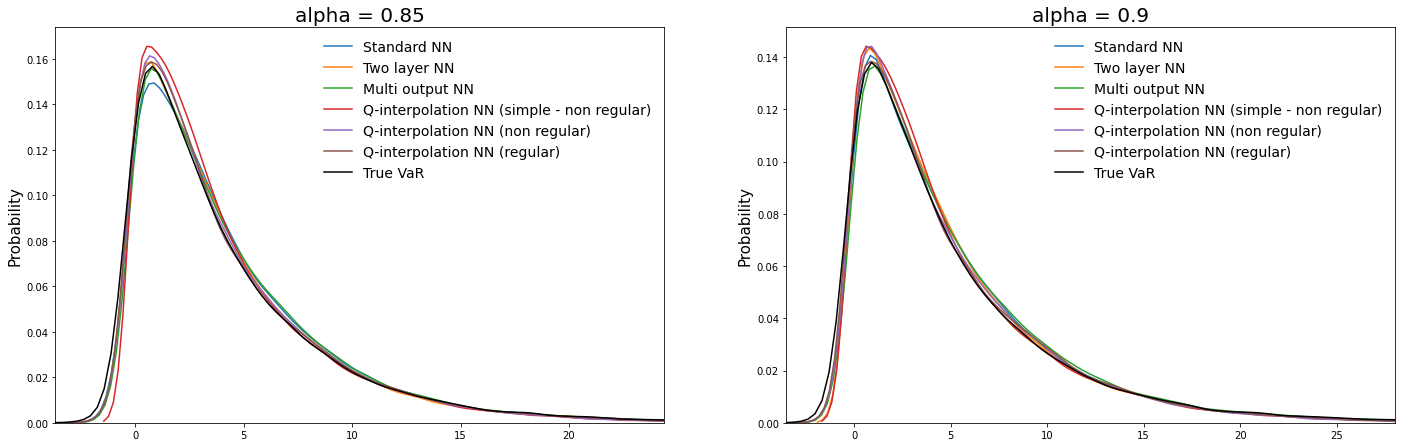

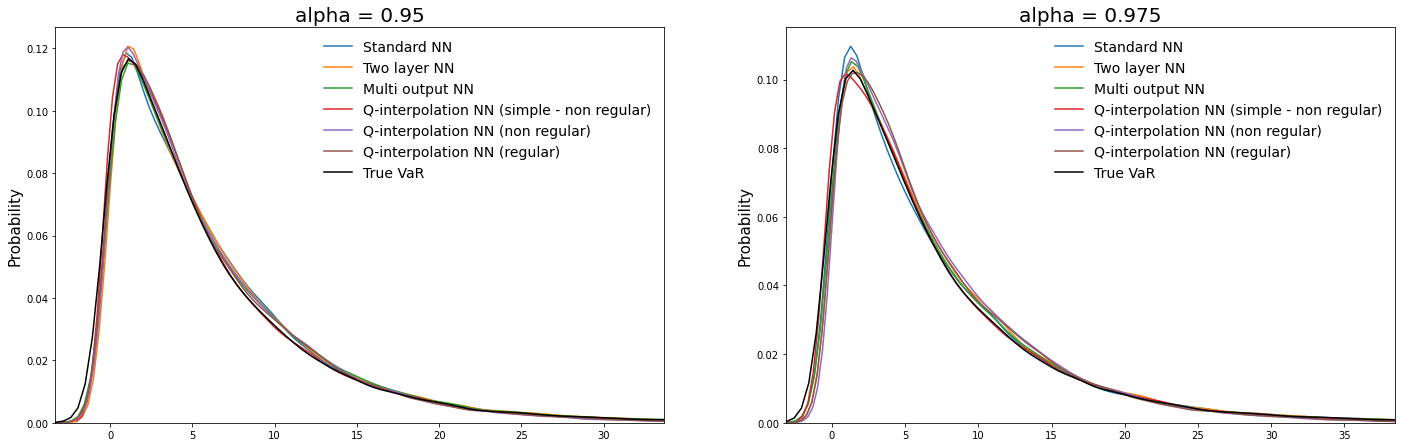

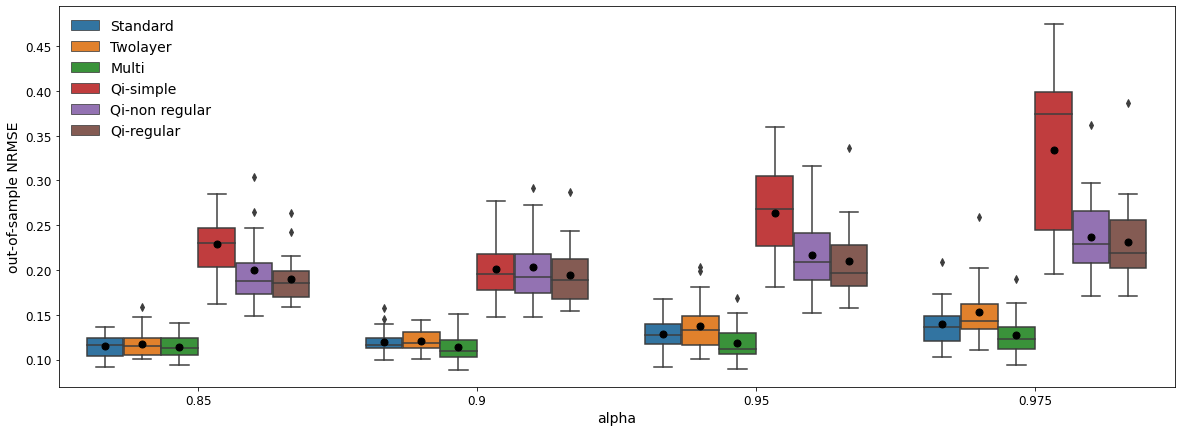

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.85, 0.9, 0.95, 0.975], dim_X = 5, lower = 0.8, upper = 1., 
                 first_density_plot = True, first_result_print = True)

###b.1 high dim - low alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.0251312255859375, 0.0495147705078125, 0.099700927734375, 0.15008544921875]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.5414896607398987, 0.606744110584259, 0.6436784863471985, 0.6328362822532654]
NRMSE out-sample VaR =  [0.5436322689056396, 0.6050636172294617, 0.6354331970214844, 0.6273557543754578]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.7028655409812927, 0.7909590601921082, 0.7597771286964417, 0.7524938583374023]
NRMSE out-sample VaR =  [0.6964825987815857, 0.7620037198066711, 0.7317848801612854, 0.7367969155311584]
====== Multi output net ======
NRMSE in-sample VaR =  [0.7893622517585754, 0.8701172471046448, 0.9445995092391968, 0.9878507852554321]
NRMSE out-sample VaR =  [0.7856426239013672, 0.8625648021697998, 0.9293590188026428, 0.9682232737541199]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.699360728263855, 0.587597370147

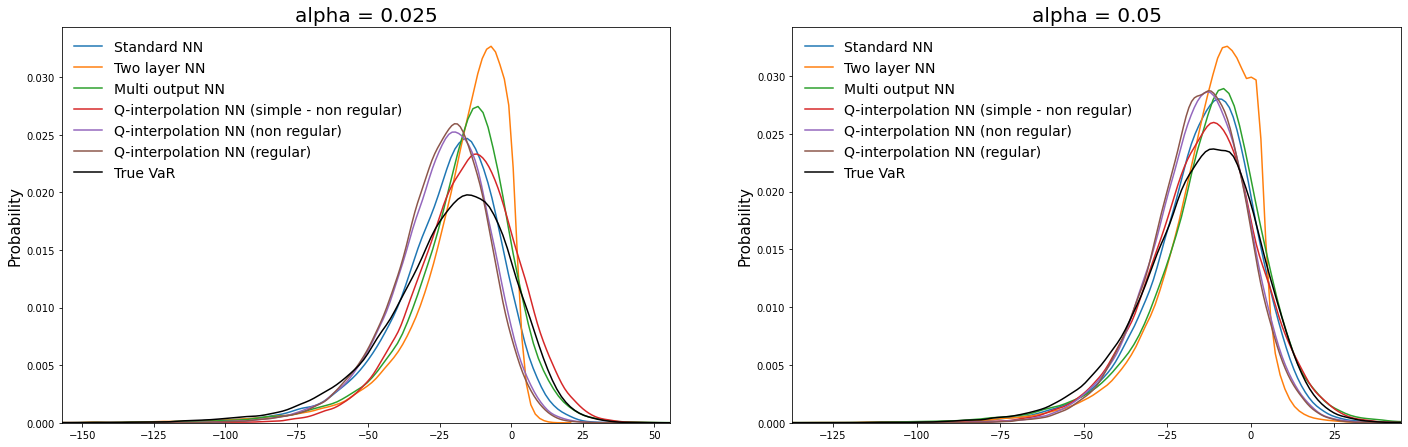

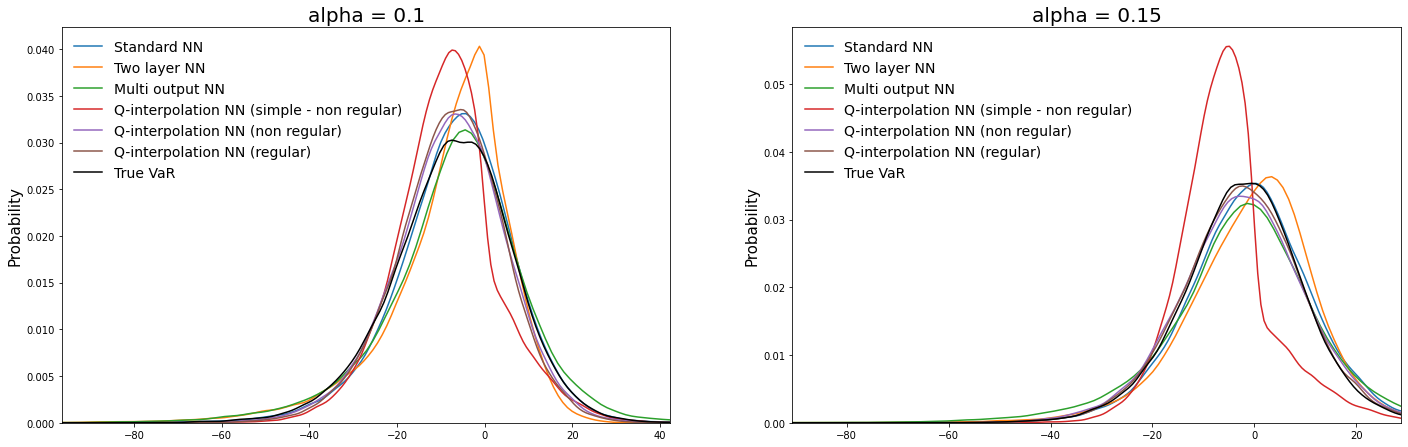

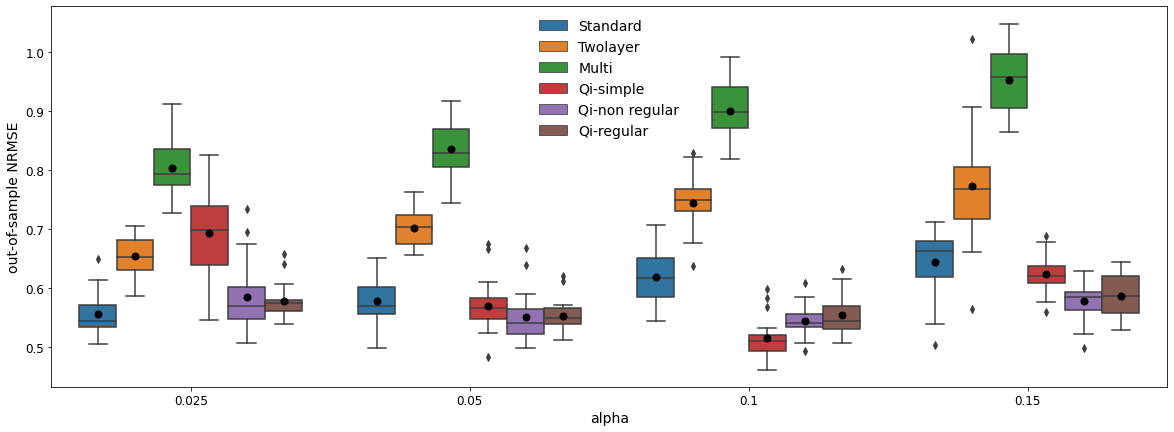

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.025, 0.05, 0.1, 0.15], dim_X = 40, lower = 0.0, upper = 0.2, 
                 first_density_plot = True, first_result_print = True)

###b.2 high dim - medium alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.4036865234375, 0.504119873046875, 0.60302734375]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.35322460532188416, 0.37481942772865295, 0.29661640524864197]
NRMSE out-sample VaR =  [0.3505949079990387, 0.3715849816799164, 0.29621922969818115]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.5144150853157043, 0.501130998134613, 0.4320145547389984]
NRMSE out-sample VaR =  [0.5130044221878052, 0.4906604290008545, 0.42347443103790283]
====== Multi output net ======
NRMSE in-sample VaR =  [0.7842955589294434, 0.6281746625900269, 0.5044625401496887]
NRMSE out-sample VaR =  [0.7718442678451538, 0.6171204447746277, 0.4930647611618042]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.4802590012550354, 0.2721056640148163, 0.2586519718170166]
NRMSE out-sample VaR =  [0.4845806658267975, 0.2749904692173004, 0.26155123114585876]
====== Quantile interpolatio

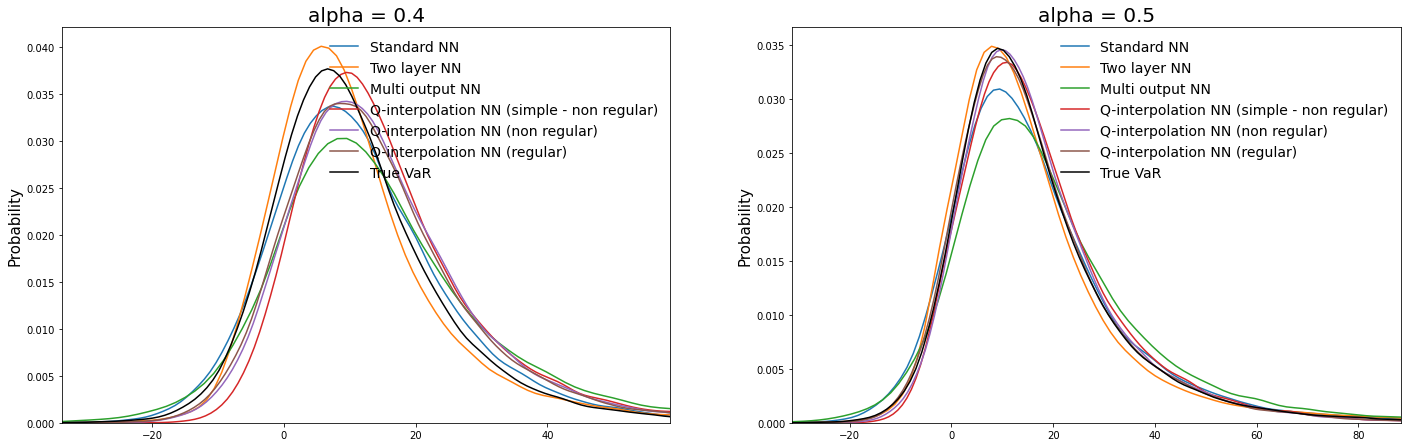

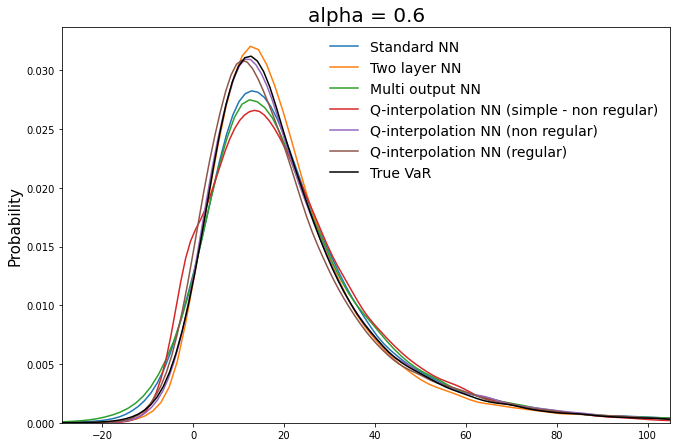

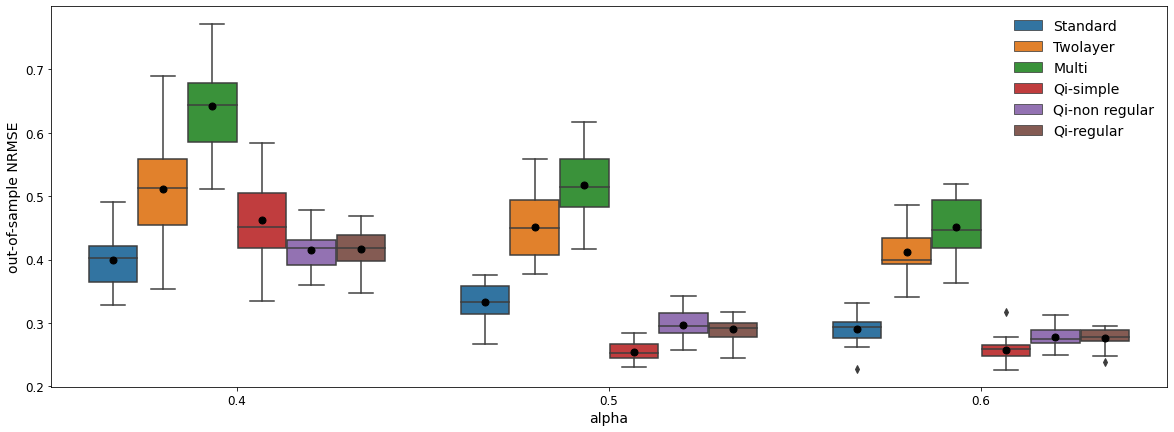

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.4, 0.5, 0.6], dim_X = 40, lower = 0.45, upper = 0.65, 
                 first_density_plot = True, first_result_print = True)

###b.3 high dim - high alpha

Empirical probability of true label being lower than true VaR (alpha) =  [0.8511505126953125, 0.9004669189453125, 0.9500885009765625, 0.975616455078125]
====== One hidden layer net ======
NRMSE in-sample VaR =  [0.2380979359149933, 0.252342164516449, 0.24695172905921936, 0.2679368555545807]
NRMSE out-sample VaR =  [0.23599709570407867, 0.25157859921455383, 0.24834679067134857, 0.2711787223815918]
====== Two hidden layer net ======
NRMSE in-sample VaR =  [0.3676697313785553, 0.3630616068840027, 0.30694088339805603, 0.3199400007724762]
NRMSE out-sample VaR =  [0.3663810193538666, 0.35772576928138733, 0.3073083460330963, 0.3226486146450043]
====== Multi output net ======
NRMSE in-sample VaR =  [0.34086352586746216, 0.30439507961273193, 0.30382823944091797, 0.3180517852306366]
NRMSE out-sample VaR =  [0.34027916193008423, 0.3040477931499481, 0.3042309284210205, 0.3184467852115631]
====== Quantile interpolation net ( simple - non regular) ======
NRMSE in-sample VaR =  [0.21469372510910034, 

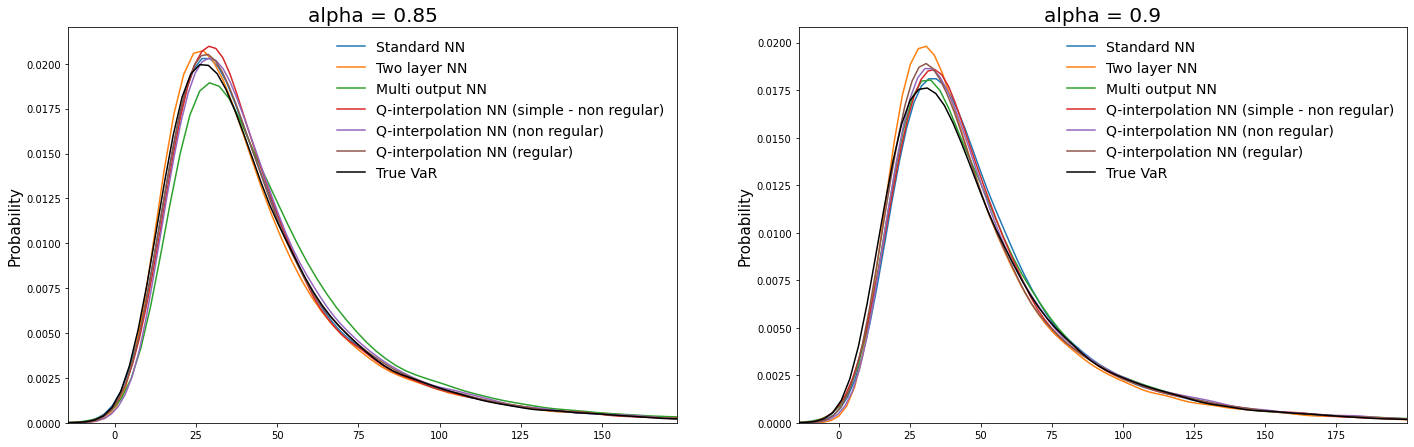

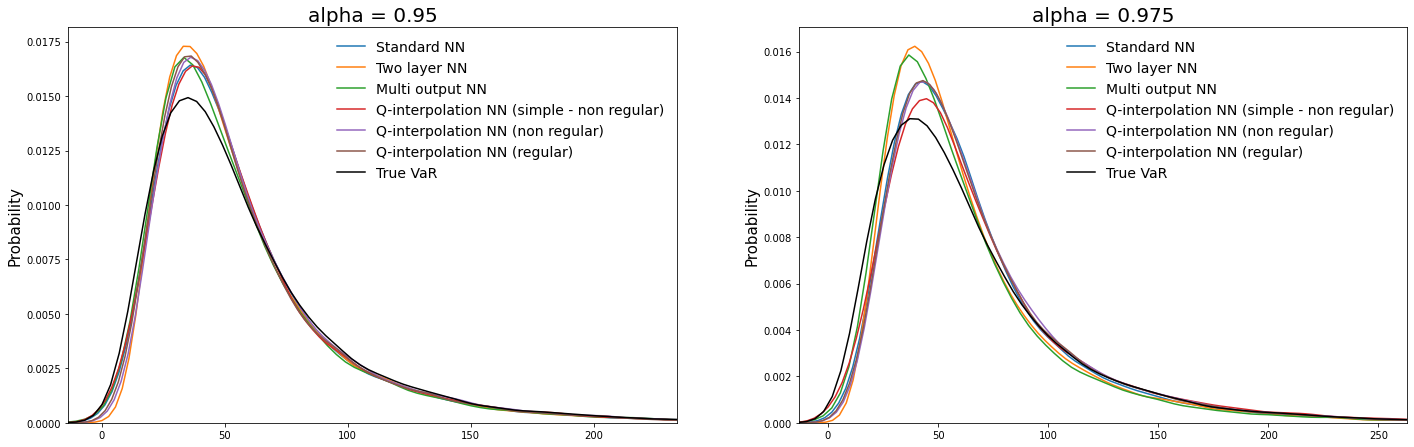

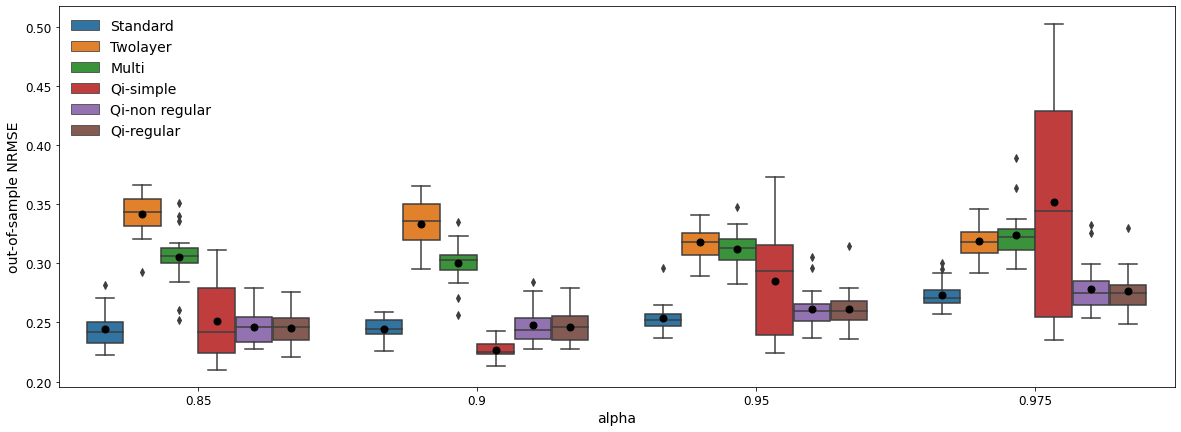

In [ ]:
boxplot_compa_func(trail = 20, alpha_l = [0.85, 0.9, 0.95, 0.975], dim_X = 40, lower = 0.8, upper = 1., 
                 first_density_plot = True, first_result_print = True)

#6 Multi-task learning comparison

In [ ]:
stop

In [ ]:
class result_generator:
    regu_h_list = ['Linf1', 'Linf2']
    regu_o_list = ['L11', 'L22', 'L21', 'Linf1']
    def __init__(self, estimator = NN_nlayers, trainer = train_var_RUbased_fullbatch,
                 eps_list = [eps, 0.01, 0.5, 0.1, 0.25],
                 param = dict(learning_rate = 0.01, regu_h_type = 'Linf2', regu_o_type = 'L22',
                              regu_h_weight = 0., regu_o_weight = 0., cross_constraint = False, 
                              schedule_lr = False, epochs=16, early_stop = 1e-8, verbose = None, batchsize = BS),
                 tuned_para = None, trail = 10):

        self.trail = trail
        self.trainer = trainer
        self.param = param
        self.estimator = estimator
        self.eps_list = eps_list
        self.eps_number = len(eps_list)
        self.model_name = ['single','single_L22','multi', 'multi_cross']+\
              ['multi_'+h+'_'+o for h in result_generator.regu_h_list for o in result_generator.regu_o_list]+['L22all']
        self.single_multi = []

        
        self.RMSE_polynormal10 = []; self.RMSE_polynormal40 = []
        self.RMSE_prob1_10 = []; self.RMSE_prob1_40 = []
        self.RMSE_prob2_10 = []; self.RMSE_prob2_40 = []
        self.RMSE_prob3_10 = []; self.RMSE_prob3_40 = []
        self.NRMSE_polynormal10 = []; self.NRMSE_polynormal40 = []
        self.NRMSE_prob1_10 = []; self.NRMSE_prob1_40 = []
        self.NRMSE_prob2_10 = []; self.NRMSE_prob2_40 = []
        self.NRMSE_prob3_10 = []; self.NRMSE_prob3_40 = []
        self.time_polynormal10 = []; self.time_polynormal40 = []
        self.time_prob1_10 = []; self.time_prob1_40 = []
        self.time_prob2_10 = []; self.time_prob2_40 = []
        self.time_prob3_10 = []; self.time_prob3_40 = []
        if tuned_para != None:
            self.tuned_para = tuned_para
            self.tune = False
        else:
            self.tuned_para = dict()
            self.tune = True
        self.data_generator = var_es_generator()
        
        
        for dim in [10,40]:
            ##### Poly Normal
            tune = self.tune            
            for i in tqdm(range(self.trail)):
                X_train, Y_train, _, _,std_Y = self.data_generator.simulate(N_sim, eps_list, dim_X = dim)
                X_test, _, true_VaR_test, _,_  = self.data_generator.simulate(N_sim, eps_list, dim_X = dim, test = True)
                l1,l2,l3,l4 = self.train(dim, X_train, Y_train, X_test, true_VaR_test,std_Y, tune = tune, prob = '0') 
                if dim == 10:    
                    self.RMSE_polynormal10.append(l1)
                    self.NRMSE_polynormal10.append(l2)
                    self.time_polynormal10.append(l3)
                else: 
                    self.RMSE_polynormal40.append(l1)
                    self.NRMSE_polynormal40.append(l2)
                    self.time_polynormal40.append(l3)
                self.single_multi.append(l4)
                del X_train, Y_train, X_test, true_VaR_test, _
                torch.cuda.empty_cache()
                gc.collect()      
                tune = False

            ##### Prob1
            tune = self.tune    
            for i in tqdm(range(self.trail)):
                X_train, Y_train, _, _,std_Y  = self.data_generator.simulate_prob1(N_sim, eps_list, dim_X = dim)
                X_test, _, true_VaR_test, _,_  = self.data_generator.simulate_prob1(N_sim, eps_list, dim_X = dim, test = True)
                l1,l2,l3,l4 = self.train(dim, X_train, Y_train, X_test, true_VaR_test,std_Y, tune = tune, prob = '1') 
                if dim == 10:    
                    self.RMSE_prob1_10.append(l1)
                    self.NRMSE_prob1_10.append(l2)
                    self.time_prob1_10.append(l3)
                else: 
                    self.RMSE_prob1_40.append(l1)
                    self.NRMSE_prob1_40.append(l2)
                    self.time_prob1_40.append(l3)
                self.single_multi.append(l4)
                del X_train, Y_train, X_test, true_VaR_test, _
                torch.cuda.empty_cache()
                gc.collect()
                tune = False    

            ##### Prob2
            tune = self.tune
            for i in tqdm(range(self.trail)):
                X_train, Y_train, _, _,std_Y  = self.data_generator.simulate_prob2(N_sim, eps_list, dim_X = dim)
                X_test, _, true_VaR_test, _,_  = self.data_generator.simulate_prob2(N_sim, eps_list, dim_X = dim, test = True)
                l1,l2,l3,l4 = self.train(dim, X_train, Y_train, X_test, true_VaR_test,std_Y, tune = tune, prob = '2') 
                if dim == 10:    
                    self.RMSE_prob2_10.append(l1)
                    self.NRMSE_prob2_10.append(l2)
                    self.time_prob2_10.append(l3)
                else: 
                    self.RMSE_prob2_40.append(l1)
                    self.NRMSE_prob2_40.append(l2)
                    self.time_prob2_40.append(l3)
                self.single_multi.append(l4)
                del X_train, Y_train, X_test, true_VaR_test, _
                torch.cuda.empty_cache()
                gc.collect()
                tune = False 

            ##### Prob3
            tune = self.tune
            for i in tqdm(range(self.trail)):
                X_train, Y_train, _, _,std_Y  = self.data_generator.simulate_prob3(N_sim, eps_list, dim_X = dim)
                X_test, _, true_VaR_test, _,_  = self.data_generator.simulate_prob3(N_sim, eps_list, dim_X = dim, test = True)
                l1,l2,l3,l4 = self.train(dim, X_train, Y_train, X_test, true_VaR_test,std_Y, tune = tune, prob = '3') 
                if dim == 10:    
                    self.RMSE_prob3_10.append(l1)
                    self.NRMSE_prob3_10.append(l2)
                    self.time_prob3_10.append(l3)
                else: 
                    self.RMSE_prob3_40.append(l1)
                    self.NRMSE_prob3_40.append(l2)
                    self.time_prob3_40.append(l3)
                self.single_multi.append(l4)
                del X_train, Y_train, X_test, true_VaR_test, _
                torch.cuda.empty_cache()
                gc.collect()
                tune = False 
        print('All calculations are done!')

    def train(self, dim, X_train, Y_train, X_test, true_VaR_test,std_Y, tune = False, prob = '0'):
        l1 = []; l2 = []; l3 = []
        l4 = []
        ### Single task
        model = self.estimator(Layers=[dim, min(dim*10, 600),1]).to(device)
        p = time.time()
        self.trainer(model, X_train, Y_train, self.eps_list[0:1], **self.param)
        #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
        l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0])) 
        l3.append(time.time()-p)
        l4.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0]))
        for j in range(self.eps_number-1):
            model.init_weights()
            self.trainer(model, X_train, Y_train, self.eps_list[(j+1):(j+2)], **self.param)
            l4[0] += NRMSE(model, X_test, true_VaR_test[:,(j+1):(j+2)],std_Y, output_range=None)
            
        l4[0] /= self.eps_number

        ### Single taskL22
        model.init_weights()
        if tune:
            best_err = np.inf
            for d_i, d_h, w_h in itertools.product([0,0.2],[0,0.2,0.5], [0.01, 0.05, 0.1, 0.005]):
                model.init_weights()                 
                model.dropout_input = d_i    
                model.dropout_hidden = d_h                    
                err = 0
                for j in range(2):
                    self.trainer(model, X_train[20000*j:20000*(j+1),:], Y_train[20000*j:20000*(j+1),:], self.eps_list[0:1], **dict(list(self.param.items()) +
                                          list(dict(regu_h_type = '', regu_o_type = 'L22all',
                                                    regu_h_weight = w_h, regu_o_weight = w_h).items())))                    
                    err += evaluate_qloss(model, X_train, Y_train, self.eps_list[0:1],output_range=[0])                 
                if err < best_err:
                    best_err = err
                    self.tuned_para[prob+'_'+str(dim)+'sing'+'__L22all'] = [d_i, d_h, w_h, w_h] 
    
        
        model.dropout_input = self.tuned_para[prob+'_'+str(dim)+'sing'+'__L22all'][0]    
        model.dropout_hidden = self.tuned_para[prob+'_'+str(dim)+'sing'+'__L22all'][1]    
        p = time.time()
        self.trainer(model, X_train, Y_train, self.eps_list[0:1], **dict(list(self.param.items()) + 
                                                list(dict(regu_h_type = '', regu_o_type = 'L22all',
                                                          regu_h_weight = self.tuned_para[prob+'_'+str(dim)+'sing'+'__L22all'][2], 
                                                          regu_o_weight = self.tuned_para[prob+'_'+str(dim)+'sing'+'__L22all'][3]).items())) )
        #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
        l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0])) 
        l3.append(time.time()-p)

        ### Multi-task no regularization
        del model
        torch.cuda.empty_cache()
        gc.collect()
        p = time.time()
        model = self.estimator(Layers=[dim,dim*10,self.eps_number]).to(device)
        #model.dropoutrate = dropoutrate
        self.trainer(model, X_train, Y_train, self.eps_list, **self.param)
        #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
        l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0])) 
        l3.append(time.time()-p)
        l4.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=None))

        ### Multi-task cross constraint
        model.init_weights()
        p = time.time()
        self.trainer(model, X_train, Y_train, self.eps_list, **dict(list(self.param.items()) + 
                                                list(dict(cross_constraint = True).items())))
        
        #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
        l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0], 
                  cross_index = list(np.array(self.eps_list).argsort()[::-1]))) 
        l3.append(time.time()-p)

        ### Multi-task regularization
        for regu_h in result_generator.regu_h_list:
            for regu_o in result_generator.regu_o_list:
                model.init_weights()
                
                if tune:
                    self.tune_function(model,dim,X_train, Y_train, regu_h, regu_o, prob = prob)
                    model.init_weights()
                model.dropout_input = self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o][0]
                model.dropout_hidden = self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o][1]
                
                p = time.time()
                self.trainer(model, X_train, Y_train, self.eps_list, **dict(list(self.param.items()) +
                                  list(dict(regu_h_type = regu_h, regu_o_type = regu_o,
                                            regu_h_weight = self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o][2], 
                                            regu_o_weight = self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o][3]).items())))
                
                #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
                l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0])) 
                l3.append(time.time()-p)

        model.init_weights()
        model.activation = F.relu
        if tune:
            self.tune_function(model,dim,X_train, Y_train, '', 'L22all', prob = prob)
            model.init_weights()
        model.dropout_input = self.tuned_para[prob+'_'+str(dim)+'__L22all'][0]
        model.dropout_hidden = self.tuned_para[prob+'_'+str(dim)+'__L22all'][1]
        p = time.time()
        self.trainer(model, X_train, Y_train, self.eps_list, **dict(list(self.param.items()) +
                          list(dict(regu_h_type = '', regu_o_type = 'L22all',
                                  regu_h_weight = self.tuned_para[prob+'_'+str(dim)+'__L22all'][2], 
                                    regu_o_weight = self.tuned_para[prob+'_'+str(dim)+'__L22all'][3]).items())))
        #l1.append(RMSE(pred[:,0], true_VaR_test[:,0]))
        l2.append(NRMSE(model, X_test, true_VaR_test,std_Y, output_range=[0])) 
        l3.append(time.time()-p)

        del model
        torch.cuda.empty_cache()
        gc.collect()
        return l1,l2,l3,l4
    
    def tune_function(self, model,dim, x_train, y_train, regu_h, regu_o, prob):
        l_droprate_i = [0,0.2]
        l_droprate_h = [0,0.2,0.5]
        l_regu_w_h = [0.005, 0.01, 0.05, 0.1]
        l_regu_w_o = [0.005, 0.01, 0.05, 0.1]
        best_err = np.inf
        if regu_h == 'Linf2': 
            for d_i, d_h, w_h, w_o in itertools.product(l_droprate_i, l_droprate_h, l_regu_w_h, l_regu_w_o):
                model.init_weights()                 
                model.dropout_input = d_i    
                model.dropout_hidden = d_h                    
                err = 0
                for j in range(2):
                    self.trainer(model, x_train[20000*j:20000*(j+1),:], y_train[20000*j:20000*(j+1),:], self.eps_list, **dict(list(self.param.items()) +
                                          list(dict(regu_h_type = regu_h, regu_o_type = regu_o,
                                                    regu_h_weight = w_h, regu_o_weight = w_o).items())))
                    
                    err += evaluate_qloss(model, x_train, y_train, self.eps_list)
                if err < best_err:
                    best_err = err
                    self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o] = [d_i, d_h, w_h, w_o]     
        else: 
            for d_h, w_h, w_o in itertools.product(l_droprate_h, l_regu_w_h, l_regu_w_o):
                if regu_h == '' and regu_o == 'L22all' and w_h !=w_o:
                    continue
                model.init_weights()                                 
                model.dropout_input = 0    
                model.dropout_hidden = d_h      
                err = 0
                for j in range(2):
                    self.trainer(model, x_train[20000*j:20000*(j+1),:], y_train[20000*j:20000*(j+1),:], self.eps_list, **dict(list(self.param.items()) +
                                          list(dict(regu_h_type = regu_h, regu_o_type = regu_o,
                                                    regu_h_weight = w_h, regu_o_weight = w_o).items())))
                    err += evaluate_qloss(model, x_train, y_train, self.eps_list,output_range=[0])
                if err < best_err:
                    best_err = err
                    self.tuned_para[prob+'_'+str(dim)+'_'+regu_h+'_'+regu_o] = [0, d_h, w_h, w_o]                         

    def plot(self):
        a = pd.DataFrame(self.single_multi)
        a.rename({0:'single', 1:'multi'}, inplace = True, axis = 1)
        a = a.stack().reset_index()
        a['Problem'] = [i for i in ['poly_dim10','poly_dim40', 'prob1_10', 'prob1_40', 'prob2_10', 'prob2_40','prob3_10', 'prob3_40'] 
                        for _ in range(self.trail*2)]
        a.rename({0:'NRMSE', 'level_1':'model'}, inplace = True, axis = 1)
        plt.figure(figsize=(14,8))
        g1 = sns.boxplot(x="Problem", y='NRMSE', data=a, hue = 'model', showfliers = True,
                         showmeans=True, meanprops={"marker":"o",
                                                        "markerfacecolor":"red", 
                                                        "markeredgecolor":"red",
                                                        "markersize":"8"})
        plt.xticks(size = 12)
        plt.xlabel("", fontsize = 14)
        plt.ylabel("out-of-sample NRMSE", fontsize = 14)
        plt.legend(fontsize = 15)
        plt.title(label = 'Average NRMSE over all quantile levels', fontdict={'size' : 14})
        plt.show()
        print('==================================================================')
        for i,(l_NRMSE10, l_NRMSE40, l_time10, l_time40) in enumerate(zip([self.NRMSE_polynormal10, self.NRMSE_prob1_10, 
                                             self.NRMSE_prob2_10, self.NRMSE_prob3_10],
                                            [self.NRMSE_polynormal40, self.NRMSE_prob1_40, 
                                             self.NRMSE_prob2_40, self.NRMSE_prob3_40],
                                            [self.time_polynormal10, self.time_prob1_10, 
                                             self.time_prob2_10, self.time_prob3_10],
                                            [self.time_polynormal40, self.time_prob1_40,
                                             self.time_prob3_40, self.time_prob3_40])):
            di = {0: '===== Poly normal problem =====',
                  1: '===== Problem 1 =====',
                  2: '===== Problem 2 =====',
                  3: '===== Problem 3 ====='}
            print(di[i])

            a = pd.DataFrame(l_NRMSE10, columns=self.model_name)
            a = a.T.stack().reset_index().rename({0:"NRMSE"}, axis =1)
            b = pd.DataFrame(l_NRMSE40, columns=self.model_name)
            b = b.T.stack().reset_index().rename({0:"NRMSE"}, axis =1)
            c = pd.DataFrame(l_time10, columns=self.model_name)
            c = c.T.stack().reset_index()
            c = c[['level_0',0]].groupby('level_0', sort= False).mean().reset_index().rename({0:"time"}, axis =1)
            d = pd.DataFrame(l_time40, columns=self.model_name)
            d = d.T.stack().reset_index()
            d = d[['level_0',0]].groupby('level_0', sort= False).mean().reset_index().rename({0:"time"}, axis =1)

            plt.figure(figsize=(20,5))
            plt.subplot(121)
            g1 = sns.boxplot(x="level_0", y='NRMSE', data=a, showfliers = True,
                             showmeans=True, meanprops={"marker":"o",
                                                        "markerfacecolor":"red", 
                                                        "markeredgecolor":"red",
                                                        "markersize":"7"})
            plt.xticks(size = 12)
            g1.set_xticklabels(self.model_name, rotation=30)
            plt.xlabel("", fontsize = 14)
            plt.ylabel("out-of-sample NRMSE (dim = 10)", fontsize = 14)
            plt.ylim(0, 1)
            ax2 = g1.twinx()
            sns.pointplot(data=c, x = 'level_0', y ='time', ax = ax2, linestyles='')
            plt.ylabel("Computation time (s)", fontsize = 14)

            plt.subplot(122)
            g1 = sns.boxplot(x="level_0", y='NRMSE', data=b, showfliers = True,
                            showmeans=True, meanprops={"marker":"o",
                                                        "markerfacecolor":"red", 
                                                        "markeredgecolor":"red",
                                                        "markersize":"7"})
            plt.xticks(size = 12)
            g1.set_xticklabels(self.model_name, rotation=35)
            plt.xlabel("", fontsize = 14)
            plt.ylabel("out-of-sample NRMSE (dim = 40)", fontsize = 14)
            plt.ylim(0, 1)
            ax2 = g1.twinx()
            sns.pointplot(data=d, x = 'level_0', y ='time', ax = ax2, linestyles='')
            plt.ylabel("Computation time (s)", fontsize = 14)
            plt.xlabel("", fontsize = 12)
            plt.show()

In [ ]:
result = result_generator(trail =20)

In [ ]:
save_obj(result.tuned_para, 'aa2')

In [ ]:
result.plot()

In [ ]:
breakkkkk

In [ ]:
def train_var_huberloss(model, X_train_var, y_train, eps = eps, 
                        regularization_weight = 0., learning_rate = 0.1,
                        epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quantile loss function training Huber loss

    This function trains Pytorch neural network module by Adam optimizer 
    training Huber loss. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """
    optimizer_var = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    tau = 2**-8
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        # Compute Huber loss
        pred = model(X_train_var)
        loss_var = huber_loss(pred, y_train, tau, eps)
        #Save best model
        if err < best_err:
            best_err = err
            best_state = copy.deepcopy(model.state_dict()) 
        loss_var.backward()
        optimizer_var.step()
        
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
        #if i % 10 ==0:
        tau *= 2**(-1)
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model.load_state_dict(best_state)
    model.eval()

In [ ]:
var_NN_Huber = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_huberloss(var_NN_Huber, X_train_var= X_train, y_train= Y_train, eps = eps,
                    learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)

In [ ]:
var_NN_Huber = NN_nlayers(Layers=[dim_X,20,2], activation =F.elu,normalization=True).to(device)
train_var_RUbased_fullbatch(var_NN_Huber, X_train, Y_train, eps_list = [eps,0.1],
                         learning_rate = 0.01, regularization_type = 'L2',
                         regu_weight = 0., regu_weight2 = 0., huber = False,
                         epochs=100, early_stop = 1e-8, verbose = 20)

In [ ]:
pred = var_NN_Huber(X_test)

In [ ]:
plot_function(var_NN_Huber(X_train)[:,0], true_VaR_train[:,0],
              true_ES_train[:,0], true_ES_train[:,0],
              var_NN_Huber(X_test)[:,0], true_VaR_test[:,0],
              true_ES_test[:,0], true_ES_test[:,0])

In [ ]:
a= var_NN_Huber.hidden[0]

In [ ]:
sum([i.shape for i in a.parameters])

In [ ]:
data_simulator()

In [ ]:
X_train -= X_train.min(0, keepdim=True)[0]

In [ ]:
X_train /= X_train.max(0, keepdim=True)[0]

In [ ]:
A = torch.tensor([[1,2],[8,2.]])

In [ ]:
torch.det(A)

In [ ]:
A

In [ ]:
model = NN_nlayers(Layers= (1,10,2))

# Joint approach

In [ ]:
data_generator = var_es_generator(dim_X =100)

NRMSE_var = []; NRMSE_es = []; compu_time = []
model = NN_nlayers(Layers= (100,600,2)).to(device)
for i in tqdm(range(20)):
    X_train, Y_train, true_VaR_train, true_ES_train, _, _ = data_generator.simulate(N_sim, eps, dim_X = 100)
    X_test, Y_test, true_VaR_test, true_ES_test, _, _ = data_generator.simulate(N_sim, eps, dim_X = 100)
    a = Y_train.std()

    l1 = []; l2 = []; l3 = []
    model.init_weights()
    p = time.time()
    joint_train_var_es_model(model, X_train, Y_train,
                             learning_rate = 0.05, regu_h_type = 'Linf2', regu_o_type = 'L22-all',
                              regu_h_weight = 0., regu_o_weight = 0.,
                              epochs=300, verbose = None)

    pred = model(X_test)
    l1.append(NRMSE(pred[:,0], true_VaR_test[:,0]))
    l2.append(NRMSE(pred[:,1], true_ES_test[:,0])) 
    l3.append(time.time()-p)
    p = time.time()
    joint_train_var_es_model(model, X_train, Y_train,
                             learning_rate = 0.05, regu_h_type = 'Linf2', regu_o_type = 'L22-all',
                              regu_h_weight = 0., regu_o_weight = 0.02,
                              epochs=300, verbose = None)

    pred = model(X_test)
    l1.append(NRMSE(pred[:,0], true_VaR_test[:,0]))
    l2.append(NRMSE(pred[:,1], true_ES_test[:,0])) 
    l3.append(time.time()-p)
    for regu_h in result_generator.regu_h_list:
        for regu_o in result_generator.regu_o_list:
            model.dropoutrate = 0.3
            model.init_weights()
            p = time.time()
            joint_train_var_es_model(model, X_train, Y_train,
                              learning_rate = 0.05, regu_h_type = regu_h, regu_o_type = regu_o,
                              regu_h_weight = 0.01, regu_o_weight = 0.03, optim_2_step = True,
                              epochs=300, verbose = None)
            pred = model(X_test)
            l1.append(NRMSE(pred[:,0], true_VaR_test[:,0]))
            l2.append(NRMSE(pred[:,1], true_ES_test[:,0])) 
            l3.append(time.time()-p)
    NRMSE_var.append(l1)
    NRMSE_es.append(l2)
    compu_time.append(l3)
    del X_train, Y_train, X_test, true_VaR_test, _
    torch.cuda.empty_cache()
    gc.collect()      
    

In [ ]:
model_name = ['multi', 'multi_L2 all']+\
              ['multi_'+h+'_'+o for h in result_generator.regu_h_list for o in result_generator.regu_o_list]
a = pd.DataFrame(NRMSE_var, columns=model_name)
a = a.T.stack().reset_index().rename({0:"NRMSE"}, axis =1)
b = pd.DataFrame(NRMSE_es, columns=model_name)
b = b.T.stack().reset_index().rename({0:"RMSE"}, axis =1)
c = pd.DataFrame(compu_time, columns=model_name)
c = c.T.stack().reset_index()
c = c[['level_0',0]].groupby('level_0', sort= False).mean().reset_index().rename({0:"time"}, axis =1)

plt.figure(figsize=(20,5))
plt.subplot(121)
g1 = sns.boxplot(x="level_0", y='NRMSE', data=a, showfliers = True,
                  showmeans=True, meanprops={"marker":"o",
                                            "markerfacecolor":"red", 
                                            "markeredgecolor":"red",
                                            "markersize":"10"})
plt.xticks(size = 12)
g1.set_xticklabels(model_name, rotation=30)
plt.xlabel("", fontsize = 14)
plt.ylabel("out-of-sample NRMSE for VaR", fontsize = 14)
plt.ylim(0, 1)
ax2 = g1.twinx()
sns.pointplot(data=c, x = 'level_0', y ='time', ax = ax2, linestyles='')
plt.ylabel("Computation time (s)", fontsize = 14)
plt.subplot(122)
g1 = sns.boxplot(x="level_0", y='RMSE', data=b, showfliers = True,
                showmeans=True, meanprops={"marker":"o",
                                            "markerfacecolor":"red", 
                                            "markeredgecolor":"red",
                                            "markersize":"10"})
plt.xticks(size = 12)
g1.set_xticklabels(model_name, rotation=30)
plt.xlabel("", fontsize = 14)
plt.ylabel("out-of-sample NRMSE for ES", fontsize = 14)
ax2 = g1.twinx()
sns.pointplot(data=c, x = 'level_0', y ='time', ax = ax2, linestyles='')
plt.ylabel("Computation time (s)", fontsize = 14)
plt.xlabel("", fontsize = 12)
plt.show()

# RBF network

In [ ]:
class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.sigmas, 1)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) * self.sigmas.unsqueeze(0)
        return self.basis_func(distances)



# RBFs

def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

In [ ]:
class RBF_net(nn.Module):
    
    def __init__(self, Layers = [40,400,1], basis_func = matern52):
        super(RBF_net, self).__init__()
        self.hidden = nn.ModuleList()
        self.hidden.append(RBF(Layers[0], Layers[1], basis_func))
        self.hidden.append(nn.Linear(Layers[1], Layers[2]))
        self.init_weights()
    
    def forward(self, x):
        
        for l in self.hidden:
            x = l(x)
        return x

    def init_weights(self):
        self.hidden.apply(NN_nlayers.initialization)